
# Исследование объявлений о продаже квартир<a id="start"></a>

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

В нашем распоряжении находится датасэт в объеме 23 тысячи строк со следующими параметрами:
-	airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
-	balcony — число балконов
-	ceiling_height — высота потолков (м)
-	cityCenters_nearest — расстояние до центра города (м)
-	days_exposition — сколько дней было размещено объявление (от публикации до снятия)
-	first_day_exposition — дата публикации
-	floor — этаж
-	floors_total — всего этажей в доме
-	is_apartment — апартаменты (булев тип)
-	kitchen_area — площадь кухни в квадратных метрах (м²)
-	last_price — цена на момент снятия с публикации
-	living_area — жилая площадь в квадратных метрах(м²)
-	locality_name — название населённого пункта
-	open_plan — свободная планировка (булев тип)
-	parks_around3000 — число парков в радиусе 3 км
-	parks_nearest — расстояние до ближайшего парка (м)
-	ponds_around3000 — число водоёмов в радиусе 3 км
-	ponds_nearest — расстояние до ближайшего водоёма (м)
-	rooms — число комнат
-	studio — квартира-студия (булев тип)
-	total_area — площадь квартиры в квадратных метрах (м²)
-	total_images — число фотографий квартиры в объявлении

Для более комплексного анализа я предложил бы обогатить данные следующими параметрами:
- год постройки дома
- расстояние до длижайшего детского сада, школы
- сколько раз продавалась квартира раньше



In [ ]:
### Обогащение  и исследование данных (#25)

### Оглавление: <a id="toc"></a>

1. [Получение данных](#1)
2. [Обогащение  и исследование данных](#2)
3. [Построение Embedings](#3)
4. [Поиск дубля на примере одной статьи](#4)
5. [Общий вывод](#5)


### Шаг 1. Откройте файл с данными и изучите общую информацию.  <a id="15"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
#import matplotlib as plt
%matplotlib inline
import matplotlib.pyplot as plt
#from matplotlib import pyplot as plt
import plotly.express as pl
%pylab inline
from pandas.plotting import scatter_matrix

Populating the interactive namespace from numpy and matplotlib


In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
except:
    print('Не удалось загрузить данные')

In [3]:
#проанализируем объем выборки, типы столбцов, пропущенные значения в них, индексы
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Мы видим что почти у половины столбцов есть пропуски в значениях:
- ceiling_height
- floors_total 
- living_area  
- is_apartment
- kitchen_area 
- balcony
- locality_name
- airports_nearest
- cityCenters_nearest
- parks_around3000
- parks_nearest 
- ponds_nearest
- days_exposition       



Предположим что некоторые не были указаны по причинам сбоя ПО/при сборе данных от пользователей, невозможности их предоставления или бессмысленности(расстояние до центра в маленьких населенных пунктах). А некоторые могли быть не указаны умышленно.



In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


Обратим внимание  на средние значения  квантили, стандартное отклонение по каждому столбцу.
Не стоит строить больших ожиданий, большие разбросы СКО обьяснимы не только не обработанными данными, но разными объектами недвижимости. Логично будет рассматривать объекты недвижимости из одного ценового диапазона.
> Я бы выделил  базовые столбцы в нашей выборке, которые наиболее важны при покупке:
- total_area — площадь квартиры в квадратных метрах (м²)
- rooms — число комнат
- locality_name — название населённого пункта
- cityCenters_nearest — расстояние до центра города
- last_price — цена на момент снятия с публикации (предполагаемая цена продажи)
> Это конечно же цена, общая площадь, расстояние до центра города, ну и населенный пункт где мы их смотрим. Не можем же мы сравнивать расстояния в Санкт-Петербурге и маленькими населенными пунктами.
Учтем эти параметры в дальнейшем для формирования фильтров


In [5]:
#Посмотрим как выглядят данные. Возьмем 20 столбцов из выборки
display(data[-2000:-1990])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21699,20,29000000.0,193.0,2017-07-10T00:00:00,3,3.35,6.0,111.0,3,NaN,...,42.0,NaN,Санкт-Петербург,24564.0,4782.0,1.0,674.0,0.0,NaN,224.0
21700,4,3390000.0,46.0,2018-01-18T00:00:00,2,NaN,5.0,30.0,1,NaN,...,7.0,NaN,Санкт-Петербург,17487.0,16689.0,0.0,NaN,0.0,NaN,5.0
21701,20,4150000.0,45.7,2017-12-06T00:00:00,1,NaN,26.0,18.0,15,NaN,...,13.1,1.0,посёлок Парголово,53963.0,18129.0,0.0,NaN,0.0,NaN,167.0
21702,9,2349000.0,23.4,2016-05-19T00:00:00,1,2.70,20.0,16.0,8,False,...,NaN,1.0,деревня Новое Девяткино,NaN,NaN,NaN,NaN,NaN,NaN,34.0
21703,8,4590000.0,45.0,2016-12-11T00:00:00,2,2.75,12.0,25.5,6,NaN,...,7.1,NaN,Санкт-Петербург,51152.0,14152.0,0.0,NaN,0.0,NaN,363.0
21704,8,2400000.0,52.0,2017-07-21T00:00:00,3,NaN,5.0,36.4,2,NaN,...,6.1,1.0,поселок городского типа Дубровка,NaN,NaN,NaN,NaN,NaN,NaN,6.0
21705,13,8300000.0,93.0,2018-12-09T00:00:00,3,2.70,16.0,45.0,16,NaN,...,15.0,NaN,Санкт-Петербург,32775.0,13874.0,0.0,NaN,1.0,1015.0,NaN
21706,5,4330000.0,56.0,2017-12-25T00:00:00,2,2.70,5.0,30.0,5,NaN,...,10.0,NaN,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,91.0
21707,5,7800000.0,59.0,2018-01-20T00:00:00,3,2.60,10.0,NaN,5,NaN,...,NaN,NaN,Санкт-Петербург,38951.0,8210.0,1.0,453.0,1.0,820.0,60.0
21708,10,3600000.0,30.0,2018-06-19T00:00:00,1,2.50,9.0,NaN,4,NaN,...,NaN,NaN,Санкт-Петербург,10493.0,14859.0,0.0,NaN,1.0,734.0,59.0


### Вывод

Отметим, что продавцы часто не указывали жилую площадь, возомжно они не знали где посмотреть эту информацию

Для анализа рыночной стоимости обектов недвижимости размерностью в 22 столбца и 23,6 тысячи строк.
Количество значений в столбцах различается. Это говорит о том, что в данных есть пропущенные значения. Перечислим столбцы с пропущенными значениями:
- ceiling_height
- floors_total 
- living_area  
- is_apartment
- kitchen_area 
- balcony
- locality_name
- airports_nearest
- cityCenters_nearest
- parks_around3000
- parks_nearest 
- ponds_nearest

В данных конечно же есть выбросы и нулевые значения, которые нам предстоит заполнить, но попытаемся все же сделать промежуточные выводы:
- медианное время объекта на продаже 95 дней. Но очень большое СКО. Значит какие то объекты продаются быстро, а какие то висят. Но нужно знать причину, возможно это мошеннические объявления, которые быстро снимают.
- очень большой разброс значений по столбцам cityCenters_nearest, airports_nearest,parks_nearest, ponds_nearest. Скорее это говорит о том что объекты разбросаны по всему городу равномерно, но не исключаем отсутстве достоверных данных. Возможно дело в отдаленных населенных пунктах
- Рассмотрев квантили и медиану параметров cityCenters_nearest и airports_nearest в формате 25%:50%:75% убедимся что расстояния в целом адекватные 9.2:13:16.3 (до центра) и 18.5:26.7:37.3(аэропорт)
- очень большой разброс значений по столбцам cityCenters_nearest, airports_nearest,parks_nearest, ponds_nearest. Скорее это говорит о том что объекты разбросаны по всему городу равномерно, но не исключаем отсутстве достоверных данных
- рассмотрев квантили и медиану параметров cityCenters_nearest и airports_nearest в формате 25%:50%:75% убедимся что расстояния в целом адекватные 9.2:13:16.3 (до центра) и 18.5:26.7:37.3(аэропорт)
- с площадью кухни тоже вроде все впорядке 7:9:12 кв. м соответственно. Есть конечно выбросы 1,3 и 112, с ними будем работать.
- по этажам статистика по этажам, если брать по квантилям 2:4:8 немножко странная для мегаполиса. Но возможно сыграл роль старый фонд и область. 
- посмотрим так же параметры самих домов •	floors_total . 60 этажей в доме - сомнительно. Да и статистика по квантилям немного выше, чем у продающихся квартир 5:9:16. Можно предположить что что-то не так с данными или от нижних этажей избавляются охотнее, а солнечные квартиры   с хорошим видом редко поступают в продажу
-что касается жилой площади   значения адекватны 18:30:42.3. С общей площадью ситуация впорядке 40:52:70. Есть квартиры 900 квадратов, но предположим что это элитная недвижимость. 
- С потолками все в норме 2.52:2.65:2.8 Но с выбросами в 100 метров нужно что-то делать, как и 1 метр тоже не годен для полноценного проживания.(скорее всего ошибка при формировании данных)
- по количеству комнат все впорядке, будем смотреть внимательней на квартиры с 19 комнатами и где нет ни одной. Может техническая ошибка при записи/копировании/заведении данных, а может там продается что то особенное.
- количество фото тоже выглядит правдоподобным 6:9:14
-цена 3.4:4.6:6.8 млн. руб. тоже выглядит реалистичноый

#### Пропущенные данные
- Высота потолков и жилая площадь, площадь кухни - возможно хозяева не владели данной информацией, или просто не стали заморачиваться и смотреть в паспорт. Скорее всего данное поле было не обязательным для заполнения
- is_apartment - скорее всего владельцы пропустили данный пункт, если у них обычная квартира.
- странно что пропущены такие значения как: расстояние до центра(можно посчитать),количество водоемов в округе и время размещения. Тут однозначно какой-то сбой с данными, в следующем модуле будм думать как восстановить эти данные



### Шаг 2. Предобработка данных<a id="25"></a>

Прежде чем осуществлять приведение типов и поиск дублей оценим еще раз данные и посмотрим пропуски. 
В предыдущем разделе мы уже нашли солбцы, требующие заполнения:
- ceiling_height
- floors_total 
- living_area  
- is_apartment
- kitchen_area 
- balcony
- locality_name
- airports_nearest
- cityCenters_nearest
- parks_around3000
- parks_nearest 
- ponds_nearest

Рассмотрим подробнее каждый из них
    

In [6]:
# оценим столбцы с пропущенными значениями
#посмотрим, сколько по каждому столбцу в процентном отношении от всей выборки
_null_columns=data.isnull().sum()
_total_row = data.shape[0]
df_null_columns = pd.DataFrame(_null_columns)
df_null_columns.set_axis(['count_Nan'], axis = 'columns', inplace = True)
df_null_columns = df_null_columns[df_null_columns['count_Nan']>0]
df_null_columns['percent'] = ((df_null_columns['count_Nan']/_total_row)*100).round(1)
df_null_columns



,count_Nan,percent
ceiling_height,9195,38.8
floors_total,86,0.4
living_area,1903,8.0
is_apartment,20924,88.3
kitchen_area,2278,9.6
balcony,11519,48.6
locality_name,49,0.2
airports_nearest,5542,23.4
cityCenters_nearest,5519,23.3
parks_around3000,5518,23.3


Заметим что пропущенные значения в некоторых стоблцах одинаковы 23.3%, значит скорее всего причина пропусков в них тоже одинаковая и она технического хараткера.

In [7]:
# получим немножко информации по статистике
# нас интересуют значения межквартильного размаха по некоторым столбцам
stat_dict = {}
countable_columns = ['total_images','last_price','ceiling_height','living_area','total_area','kitchen_area']
def qantile_calc(df):
    for column_header in countable_columns: 
        #print(data[column_header].unique().sum())
        stat_25=df[column_header].describe()[4]
        stat_50=df[column_header].describe()[5]
        stat_75=df[column_header].describe()[6]
        whiskers_Q1= (stat_25-(stat_75-stat_25)*2).round(2)
        whiskers_Q3  = (stat_75+(stat_75-stat_25)*2).round(2)
        stat_dict[column_header] =[stat_25,stat_50,stat_75,whiskers_Q1,whiskers_Q3]
    return stat_dict
print(qantile_calc(data))    


{'total_images': [6.0, 9.0, 14.0, -10.0, 30.0], 'last_price': [3400000.0, 4650000.0, 6800000.0, -3400000.0, 13600000.0], 'ceiling_height': [2.52, 2.65, 2.8, 1.96, 3.36], 'living_area': [18.6, 30.0, 42.3, -28.8, 89.7], 'total_area': [40.0, 52.0, 69.9, -19.8, 129.7], 'kitchen_area': [7.0, 9.1, 12.0, -3.0, 22.0]}


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 35 37 39 42 50]


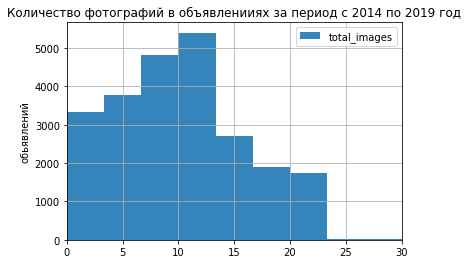

In [8]:
#оценим данные по столбцу 

print(data['total_images'].sort_values().unique())
#data.hist('total_images',bins=15)
data.plot(kind='hist', y='total_images',bins=15,grid=True,
          linewidth=5,alpha=0.9, title='Количество фотографий в объявленииях за период с 2014 по 2019 год',
         figsize=(6,4),xlim=(0,30)
#           ,ylabel ="Количество обьявлений"
         )
plt.ylabel("обьявлений")
plt.show()

Выбросов в данных по столбцу **total_images** не наблюдается. Отридцательных значений нет. Есть "толстый хвост" но он объясним. Кто то хочет лучше показать то, что он продает

In [9]:
data['last_price'] = data['last_price'].astype('uint32')
#посмотрим группировку по уникальным значениями
print(pd.Series(data['last_price'].value_counts()).head(20))
#посмотрим, есть ли жилье меньше 0
display(data.query('last_price <= 0')) 
#посмотрим супердорогие квартиры
# правую границу интерквартильного размаха умножим на 10
display(data.query('last_price >= 13600000.0*10').head())


4500000    342
3500000    291
4300000    260
4000000    260
4200000    259
3600000    257
3300000    244
3800000    240
3200000    238
3700000    234
4100000    233
3400000    227
5500000    227
3900000    221
3100000    220
4600000    216
5200000    206
5000000    199
4800000    198
5100000    194
Name: last_price, dtype: int64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1026,20,155000000,310.0,2018-10-12T00:00:00,5,5.30,3.0,190.0,3,NaN,...,63.0,2.0,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
1436,19,330000000,190.0,2018-04-04T00:00:00,3,3.50,7.0,95.0,5,NaN,...,40.0,NaN,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0
2536,16,159984000,242.4,2015-08-27T00:00:00,4,3.85,9.0,131.0,7,NaN,...,20.0,0.0,Санкт-Петербург,21946.0,2242.0,1.0,679.0,1.0,227.0,501.0
3117,19,140000000,631.0,2019-03-30T00:00:00,7,NaN,5.0,NaN,5,NaN,...,60.0,NaN,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
5893,3,230000000,500.0,2017-05-31T00:00:00,6,NaN,7.0,NaN,7,NaN,...,40.0,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0


Похоже что со столбцом **last_price** все впорядке:
- отсутствуют отридцательные цены
- у самых популярных цен круглые цифры 3.5;4.5;4.2 млн. и т.д. что говорит о нормальной модели поведения человека, выставляющего круглые цифры в объявлении
- у самых дорогих квартир большая площадь. Имеем полагать что это элитная недвижимость, оснований что это выбросы - нет

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
660,3,49950000,483.90,2017-10-04T00:00:00,7,3.2,6.0,312.5,4,NaN,...,26.40,NaN,Санкт-Петербург,23079.0,945.0,3.0,461.0,3.0,22.0,391.0
3117,19,140000000,631.00,2019-03-30T00:00:00,7,NaN,5.0,NaN,5,NaN,...,60.00,NaN,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
3676,12,28789000,441.98,2019-01-23T00:00:00,4,NaN,6.0,NaN,6,NaN,...,35.05,NaN,Санкт-Петербург,20552.0,5181.0,0.0,NaN,0.0,NaN,NaN
4237,1,50000000,517.00,2017-10-14T00:00:00,7,NaN,4.0,332.0,3,NaN,...,22.00,NaN,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN
5358,20,65000000,590.00,2019-02-14T00:00:00,15,3.5,6.0,409.0,3,NaN,...,100.00,NaN,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0


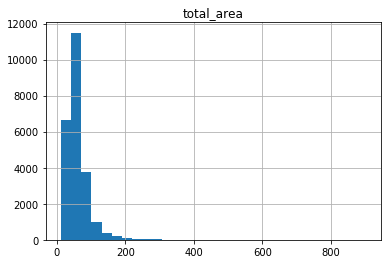

In [10]:
#оценим распределение
data.hist('total_area',bins =30)
#посмотрим данные в хвосте
display(data.query('total_area >= 400').head())

Данные распределены нормально
- отсутствуюет отридцательная площадь
- квартиры выше 400 квадратоми реально похожи на элитную недвижимость с большими кухнями и жилой площадью

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
10132,2,16137000,154.76,2014-11-27T00:00:00,4,2.70,20.0,67.81,20,NaN,...,32.55,0.0,Санкт-Петербург,18490.0,17492.0,0.0,NaN,2.0,113.0,573.0
8393,10,8037000,56.20,2014-11-27T00:00:00,1,NaN,5.0,24.20,5,False,...,12.90,0.0,Санкт-Петербург,36813.0,8572.0,1.0,2467.0,3.0,214.0,972.0
15857,6,25000000,145.20,2014-11-27T00:00:00,3,NaN,5.0,60.70,5,NaN,...,40.20,NaN,Санкт-Петербург,36779.0,14931.0,0.0,NaN,0.0,NaN,NaN
2831,9,5990000,64.40,2014-11-27T00:00:00,2,3.12,4.0,36.20,1,NaN,...,14.60,0.0,Санкт-Петербург,24668.0,5236.0,1.0,366.0,0.0,NaN,1069.0
696,1,3364930,34.69,2014-11-27T00:00:00,1,2.64,25.0,23.43,25,NaN,...,23.43,2.0,Санкт-Петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0
3486,2,14500000,97.40,2014-11-27T00:00:00,2,3.00,8.0,36.30,2,False,...,31.70,0.0,Санкт-Петербург,39393.0,11096.0,1.0,537.0,0.0,NaN,1078.0
21867,19,26360000,95.00,2014-11-27T00:00:00,3,NaN,9.0,59.80,8,NaN,...,12.20,1.0,Санкт-Петербург,26055.0,4800.0,1.0,648.0,1.0,779.0,1107.0
6726,6,11995000,83.82,2014-11-27T00:00:00,2,2.73,11.0,42.31,1,NaN,...,17.85,NaN,Санкт-Петербург,39946.0,10720.0,1.0,2102.0,3.0,303.0,1406.0
16159,5,14538350,80.55,2014-11-27T00:00:00,2,2.80,12.0,35.00,10,False,...,16.45,2.0,Санкт-Петербург,39946.0,10720.0,1.0,2102.0,3.0,303.0,1076.0
20635,10,4600000,44.00,2014-11-27T00:00:00,1,NaN,22.0,20.00,19,NaN,...,10.00,1.0,Санкт-Петербург,15268.0,13377.0,0.0,NaN,1.0,636.0,1002.0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12343,12,2890000,48.8,2019-05-03T00:00:00,2,2.55,5.0,29.4,1,NaN,...,7.2,NaN,городской посёлок Рощино,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12208,7,9000000,60.3,2019-05-03T00:00:00,2,3.25,5.0,36.9,4,NaN,...,5.8,4.0,Санкт-Петербург,32302.0,4662.0,1.0,398.0,0.0,NaN,NaN
17872,3,4650000,34.8,2019-05-03T00:00:00,1,2.50,9.0,13.9,1,NaN,...,11.2,NaN,Санкт-Петербург,12384.0,12296.0,0.0,NaN,1.0,396.0,NaN
12003,10,950000,37.1,2019-05-03T00:00:00,1,NaN,4.0,17.0,4,False,...,8.4,2.0,деревня Курковицы,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2178,10,5100000,51.0,2019-05-03T00:00:00,1,NaN,9.0,15.0,2,NaN,...,25.0,NaN,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10917,20,10000000,62.3,2019-05-03T00:00:00,2,NaN,6.0,20.0,3,NaN,...,30.0,NaN,Санкт-Петербург,25083.0,3148.0,2.0,629.0,0.0,NaN,NaN
5986,0,5000000,48.0,2019-05-03T00:00:00,3,2.50,9.0,NaN,2,NaN,...,NaN,NaN,Санкт-Петербург,51060.0,16892.0,0.0,NaN,0.0,NaN,NaN
9217,7,4300000,35.7,2019-05-03T00:00:00,1,2.70,21.0,15.0,12,False,...,13.0,2.0,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21887,0,5600000,61.6,2019-05-03T00:00:00,3,2.50,9.0,42.0,5,NaN,...,8.3,NaN,Санкт-Петербург,36326.0,10641.0,1.0,637.0,0.0,NaN,NaN
15072,5,1400000,34.0,2019-05-03T00:00:00,1,2.50,5.0,NaN,2,NaN,...,7.0,NaN,Кириши,NaN,NaN,NaN,NaN,NaN,NaN,NaN


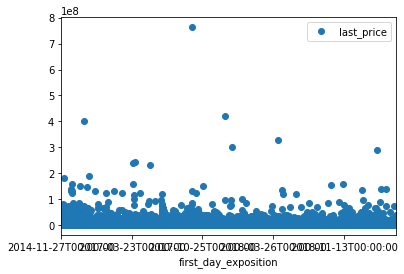

In [11]:

#? не знаю как лучше посмотреть выбросы по дате
display(data.sort_values(by ='first_day_exposition')[:10])
display(data.sort_values(by ='first_day_exposition')[-10:])

#
data.sort_values(by ='first_day_exposition').plot(x ='first_day_exposition',y='last_price',style='o')


Проанализировав столбец "first_day_exposition" поняли, что визуально выбросы отсутствуют.
Посмотрели как меняется цена во времени, есть небольшие выбросы но они не критичны

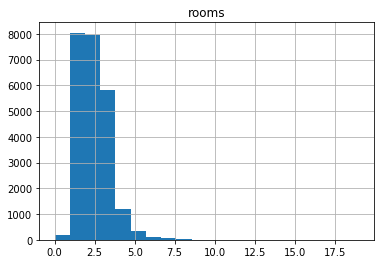

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 19]
1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64


In [12]:
#оценим распределение по количеству комнта 
data.hist('rooms',bins =20)
plt.show()
print(np.sort(data.rooms.unique()))
print(data.rooms.value_counts())

Данные по квартирам распределены нормально, при первом приближении выбросов нет.
Есть квартиры с высоким количеством комнат, но примем их за элитную недвижимость.

9195
[  1.     1.2    1.75   2.     2.2    2.25   2.3    2.34   2.4    2.45
   2.46   2.47   2.48   2.49   2.5    2.51   2.52   2.53   2.54   2.55
   2.56   2.57   2.58   2.59   2.6    2.61   2.62   2.63   2.64   2.65
   2.66   2.67   2.68   2.69   2.7    2.71   2.72   2.73   2.74   2.75
   2.76   2.77   2.78   2.79   2.8    2.81   2.82   2.83   2.84   2.85
   2.86   2.87   2.88   2.89   2.9    2.91   2.92   2.93   2.94   2.95
   2.96   2.97   2.98   2.99   3.     3.01   3.02   3.03   3.04   3.05
   3.06   3.07   3.08   3.09   3.1    3.11   3.12   3.13   3.14   3.15
   3.16   3.17   3.18   3.2    3.21   3.22   3.23   3.24   3.25   3.26
   3.27   3.28   3.29   3.3    3.31   3.32   3.33   3.34   3.35   3.36
   3.37   3.38   3.39   3.4    3.42   3.43   3.44   3.45   3.46   3.47
   3.48   3.49   3.5    3.51   3.52   3.53   3.54   3.55   3.56   3.57
   3.58   3.59   3.6    3.62   3.63   3.65   3.66   3.67   3.68   3.69
   3.7    3.75   3.76   3.78   3.8    3.82   3.83   3.84   3.85   3.86
 

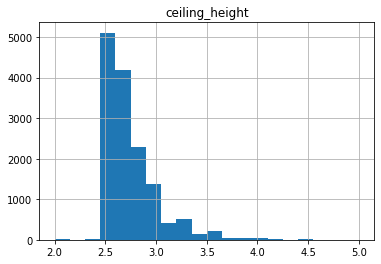

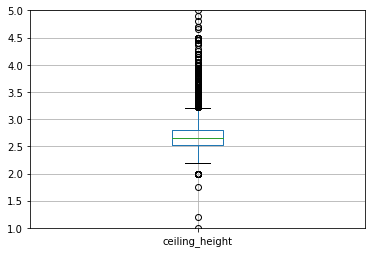

In [13]:
# рассмотрим высоту потолоков, посчитаем количество незаполнненых значений
print(data['ceiling_height'].isna().sum())
#посмотрим на упорядоченный диапазон уникальных значений
print(data['ceiling_height'].sort_values().unique())
# посмотрим какие значения самые популярные
data.hist('ceiling_height',bins=20,range=(2,5))
plt.show()
#display(data[data['ceiling_height']>5].sort_values(by='total_area'))
#посмотрим статистические данные 
data.boxplot(column = 'ceiling_height')   
plt.ylim(1, 5)
plt.show()
    
# заполним медианным значением так же где потолки в квартирах меньше 2.1 метра и больше 4 метров. 
# не берем в рассчет коммерческую и элитную недвижимость с площадью более 120 метров
data.loc[((data['ceiling_height']<2.1)|(data['ceiling_height']>4))&(data['total_area']<120), 'ceiling_height'] = 2.65
                      
#Заполним значения с NaN медианой
data['ceiling_height'] = data['ceiling_height'].fillna(2.65)
#data['ceiling_height'] = data['ceiling_height'].replace(np.nan, 2.65)
#display(data[data['ceiling_height']!=data['ceiling_height']])

- Выяснили, что высота потолков в нашей выборке подвержена распределению пуассона. В основном продаются квартиры с высотой потолков 2,5-2,8 метра.  Большее количество жилья с потолками в 2,65 метра. Этим же значением и заполним пропуске.
- Посмотрели еще недвижимость с потолками  до 2.1 метров и свыше 4 (смотрели на усы квартилей, но 3.2 показалось небольшим значением, т.к. бывают старые квартиры с высокими потолками), отбросим разного рода необычную недвижимость с большой площадью, выше 120 квадратов. 
- Получили 86 записей с обычными  квартирами, в них тоже заменим на медианное значение  2.65.
- Заполнили 9195 пропусков NaN медианным значением  2.65

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000,65.2,2018-10-02T00:00:00,2,2.65,NaN,30.80,4,NaN,...,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033,28.1,2016-11-23T00:00:00,1,2.65,NaN,20.75,1,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348,70.8,2015-08-01T00:00:00,2,2.65,NaN,38.40,12,NaN,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191,93.6,2017-04-06T00:00:00,3,2.65,NaN,47.10,8,NaN,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000,39.0,2017-04-22T00:00:00,1,2.65,NaN,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000,63.5,2017-05-24T00:00:00,2,2.80,NaN,NaN,3,NaN,...,NaN,NaN,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160,64.5,2017-04-02T00:00:00,2,2.65,NaN,31.70,20,NaN,...,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263,110.4,2016-11-20T00:00:00,3,2.65,NaN,45.38,6,NaN,...,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872,123.3,2017-04-25T00:00:00,3,2.65,NaN,50.40,18,NaN,...,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


Количество обьявлений, где не указан этаж:86


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000,65.2,2018-10-02T00:00:00,2,2.65,NaN,30.80,4,NaN,...,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033,28.1,2016-11-23T00:00:00,1,2.65,NaN,20.75,1,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348,70.8,2015-08-01T00:00:00,2,2.65,NaN,38.40,12,NaN,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191,93.6,2017-04-06T00:00:00,3,2.65,NaN,47.10,8,NaN,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000,39.0,2017-04-22T00:00:00,1,2.65,NaN,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000,63.5,2017-05-24T00:00:00,2,2.80,NaN,NaN,3,NaN,...,NaN,NaN,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160,64.5,2017-04-02T00:00:00,2,2.65,NaN,31.70,20,NaN,...,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263,110.4,2016-11-20T00:00:00,3,2.65,NaN,45.38,6,NaN,...,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872,123.3,2017-04-25T00:00:00,3,2.65,NaN,50.40,18,NaN,...,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0eb8144e10>]],
      dtype=object)

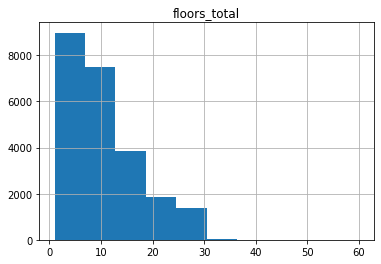

In [14]:
# 'floors_total' -86 пропущенных значений
# в выборке указаны этажи на котором квартира, но нет этажности дома. Скорее всего владелец забыл их указать
# есть идея заполнить пропущенные значения по значению этажа в этом же обьявлении.
# ? может все же не стоило заоплнять таким образом?
display(data[data['floors_total'].isnull()])
_floors_total_null = data[data['floors_total'].isnull()]
print('Количество обьявлений, где не указан этаж:{}'.format(data['floors_total'].isna().sum()))
#data.loc[data['floors_total'].isnull(),'floors_total'] = data['floor']
#проверим, корректно ли заполнилась наша выборка
display(data.query('index in @_floors_total_null.index'))
data.hist('floors_total')

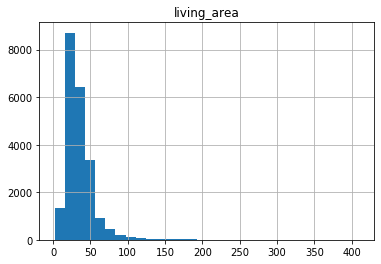

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22409,0,3200000,54.00,2017-12-16T00:00:00,2,2.50,5.0,NaN,5,NaN,...,NaN,NaN,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,38.0
22421,8,2650000,38.00,2019-03-23T00:00:00,1,2.65,9.0,NaN,7,NaN,...,10.00,2.0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22423,6,7700000,94.00,2016-03-25T00:00:00,4,2.65,4.0,NaN,4,NaN,...,NaN,0.0,Санкт-Петербург,19711.0,4120.0,1.0,701.0,1.0,60.0,295.0
22424,1,4780000,53.81,2019-02-25T00:00:00,2,2.65,16.0,NaN,9,NaN,...,NaN,NaN,городской посёлок Рощино,NaN,NaN,NaN,NaN,NaN,NaN,60.0
22427,2,8000000,93.00,2018-02-08T00:00:00,3,2.65,23.0,NaN,4,NaN,...,10.40,NaN,Санкт-Петербург,48847.0,16685.0,0.0,NaN,0.0,NaN,267.0
22437,9,4750000,45.00,2017-07-15T00:00:00,2,2.65,7.0,NaN,4,NaN,...,NaN,NaN,Санкт-Петербург,39812.0,9072.0,1.0,602.0,0.0,NaN,192.0
22449,4,3500000,67.00,2018-03-23T00:00:00,2,2.75,5.0,NaN,5,NaN,...,NaN,NaN,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,45.0
22500,7,26310000,86.70,2018-03-06T00:00:00,2,3.00,6.0,NaN,5,NaN,...,18.00,2.0,Санкт-Петербург,32859.0,5951.0,1.0,784.0,3.0,103.0,15.0
22524,8,3960000,40.10,2018-01-15T00:00:00,1,2.65,24.0,NaN,13,NaN,...,NaN,NaN,посёлок Парголово,52611.0,18783.0,0.0,NaN,0.0,NaN,69.0
22529,4,4198017,47.30,2019-01-11T00:00:00,1,2.65,4.0,NaN,1,NaN,...,9.76,NaN,Санкт-Петербург,45767.0,21700.0,0.0,NaN,1.0,576.0,45.0


total_area         living_area kitchen_area
           count  median      median       median
rooms                                            
0            197   26.05      18.000          NaN
1           8047   36.56      17.600         9.04
2           7940   53.00      30.500         8.80
3           5814   73.00      45.000         9.50
4           1180   99.30      63.600        11.10
5            326  146.45      91.785        15.10
6            105  184.30     123.900        19.50
7             59  214.00     145.000        20.00
8             12  235.70     161.000        25.00
9              8  300.95     179.200        14.30
10             3  272.60     161.400        19.80
11             2  188.90     133.900        12.60
12             1  900.00     409.700       112.00
14             2  304.20     195.150        21.25
15             1  590.00     409.000       100.00
16             1  270.00     180.000        13.00
19             1  374.60     264.500        27.60

In [15]:
#столбце living_area пропущено 1903 значения
# вспомним про данные по статистике living_area': [18.59375, 30.0, 42.3125, -16.98, 77.89]}
#оценим нашу выборку
data.hist('living_area', bins=30)
plt.show()
# оценим выборку с пропущенными значениями
NaN_living_area=data[data['living_area'].isna()].copy()
display(NaN_living_area.query('total_area<100')[-100:-90])
#есть идея сгруппровать по количеству комнат и посмотреть медианную жилую площадь, а заодно и другую статистику
#попробуем предположить, что по медианам из общей площади и площади кухни мы сможем посчитать жилую
(display(data.groupby('rooms')
.agg({'total_area':['count','median'],'living_area':'median','kitchen_area':'median' })))



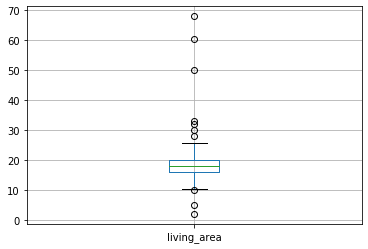

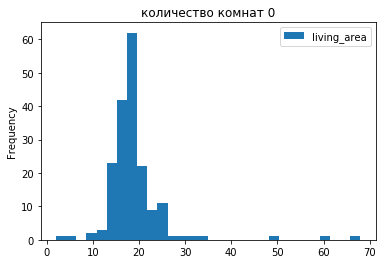

Значения  межквартильного  размаха Q1:8.1 и Q3:27.85
Количество значений за пределами: 9. Общее количество квартир с 0 комнатами: 197
Перцентиль 5% 13.541999999999998, а 95% перцентиль равен 25.0


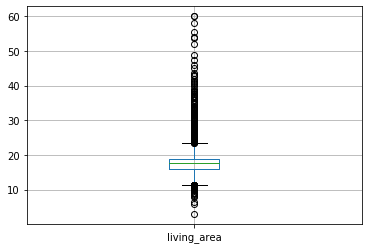

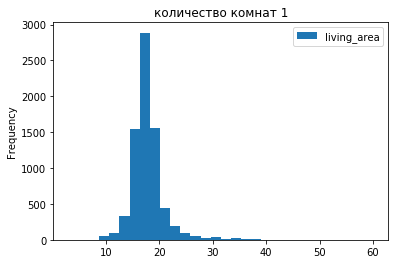

Значения  межквартильного  размаха Q1:10.0 и Q3:25.0
Количество значений за пределами: 222. Общее количество квартир с 1 комнатами: 8047
Перцентиль 5% 14.0, а 95% перцентиль равен 22.5


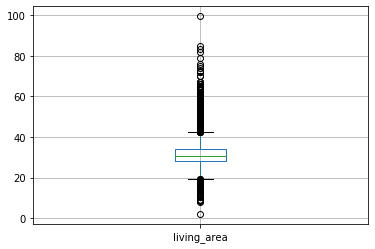

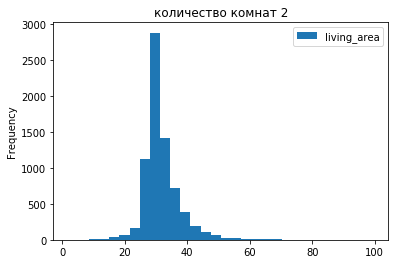

Значения  межквартильного  размаха Q1:16.5 и Q3:45.5
Количество значений за пределами: 259. Общее количество квартир с 2 комнатами: 7940
Перцентиль 5% 25.0, а 95% перцентиль равен 42.6


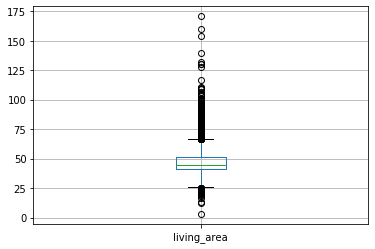

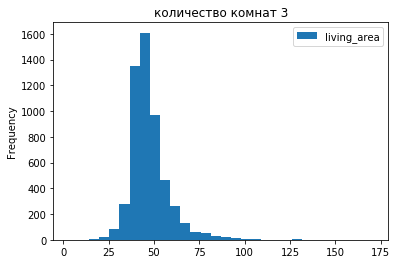

Значения  межквартильного  размаха Q1:20.4 и Q3:71.9
Количество значений за пределами: 195. Общее количество квартир с 3 комнатами: 5814
Перцентиль 5% 35.0, а 95% перцентиль равен 67.0


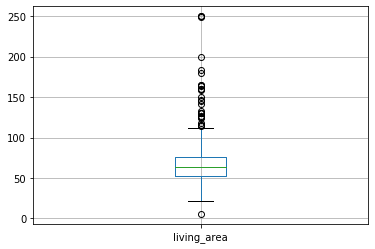

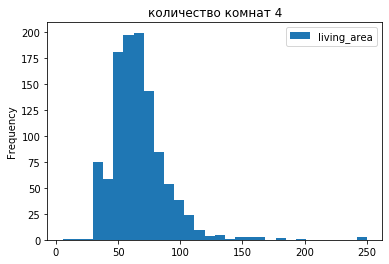

Значения  межквартильного  размаха Q1:3.2 и Q3:125.2
Количество значений за пределами: 23. Общее количество квартир с 4 комнатами: 1180
Перцентиль 5% 37.3, а 95% перцентиль равен 104.0


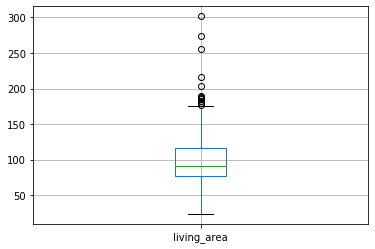

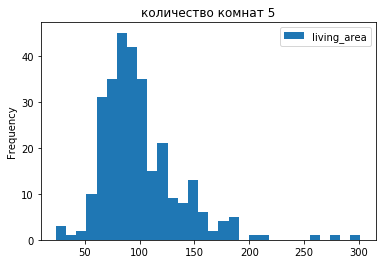

Значения  межквартильного  размаха Q1:-3.43 и Q3:196.33
Количество значений за пределами: 5. Общее количество квартир с 5 комнатами: 326
Перцентиль 5% 59.05500000000001, а 95% перцентиль равен 167.0


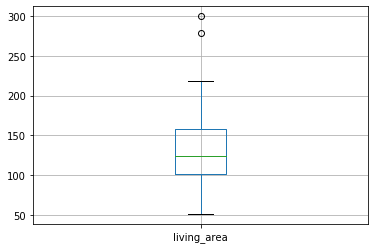

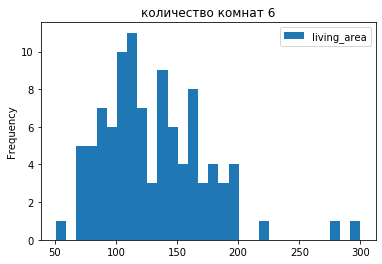

Значения  межквартильного  размаха Q1:-12.0 и Q3:270.5
Количество значений за пределами: 2. Общее количество квартир с 6 комнатами: 105
Перцентиль 5% 75.0, а 95% перцентиль равен 194.39999999999998


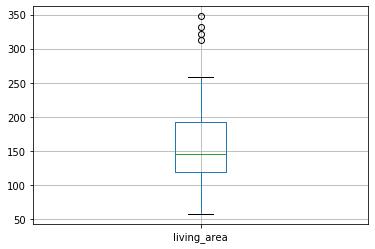

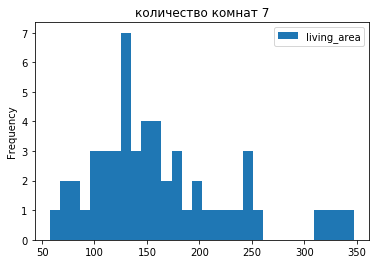

Значения  межквартильного  размаха Q1:-28.1 и Q3:340.4
Количество значений за пределами: 1. Общее количество квартир с 7 комнатами: 59
Перцентиль 5% 79.24000000000001, а 95% перцентиль равен 316.41999999999996


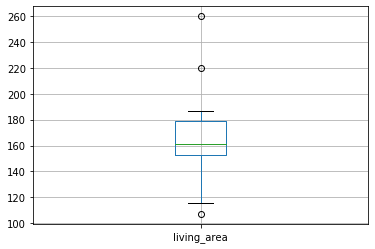

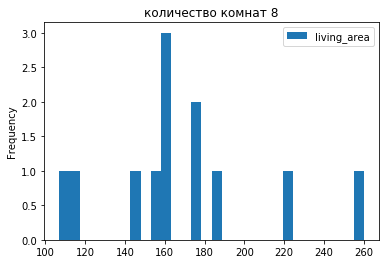

Значения  межквартильного  размаха Q1:98.8 и Q3:232.8
Количество значений за пределами: 1. Общее количество квартир с 8 комнатами: 12
Перцентиль 5% 111.84, а 95% перцентиль равен 237.99999999999997


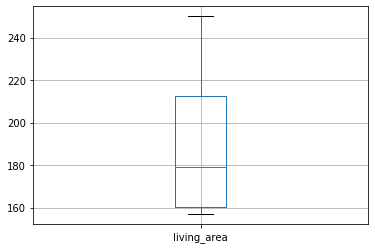

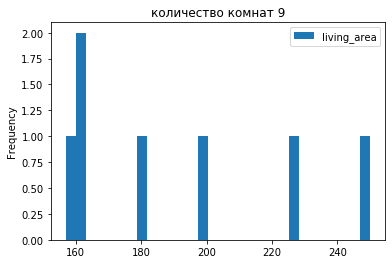

Значения  межквартильного  размаха Q1:56.15 и Q3:316.65
Количество значений за пределами: 0. Общее количество квартир с 9 комнатами: 8
Перцентиль 5% 157.93, а 95% перцентиль равен 242.76999999999998


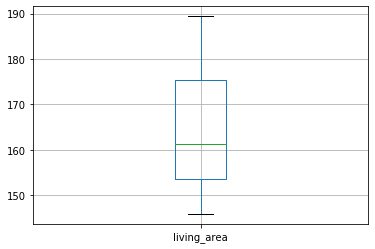

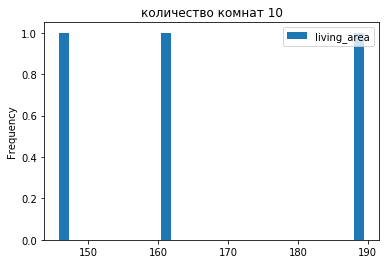

Значения  межквартильного  размаха Q1:110.15 и Q3:218.9
Количество значений за пределами: 0. Общее количество квартир с 10 комнатами: 3
Перцентиль 5% 147.45, а 95% перцентиль равен 186.6


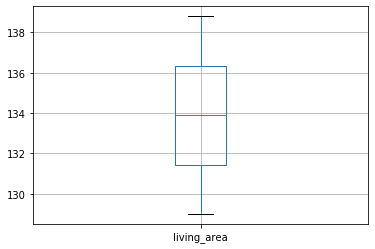

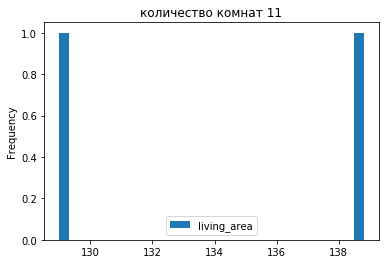

Значения  межквартильного  размаха Q1:121.65 и Q3:146.15
Количество значений за пределами: 0. Общее количество квартир с 11 комнатами: 2
Перцентиль 5% 129.49, а 95% перцентиль равен 138.31000000000003


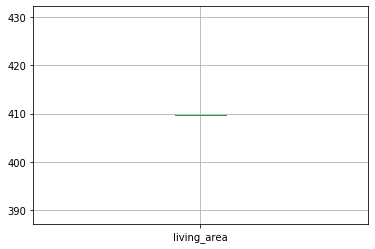

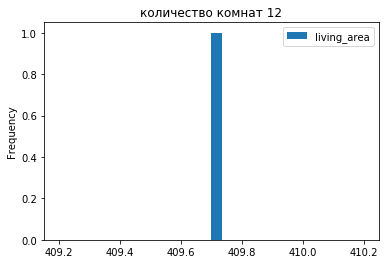

Значения  межквартильного  размаха Q1:409.7 и Q3:409.7
Количество значений за пределами: 0. Общее количество квартир с 12 комнатами: 1
Перцентиль 5% 409.7, а 95% перцентиль равен 409.7


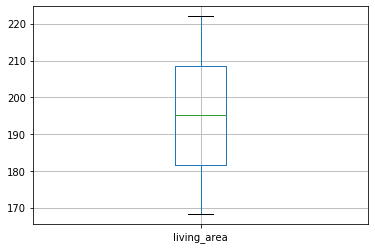

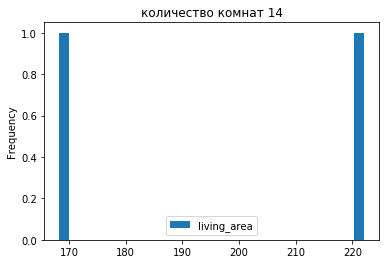

Значения  межквартильного  размаха Q1:128.03 и Q3:262.27
Количество значений за пределами: 0. Общее количество квартир с 14 комнатами: 2
Перцентиль 5% 170.98499999999999, а 95% перцентиль равен 219.315


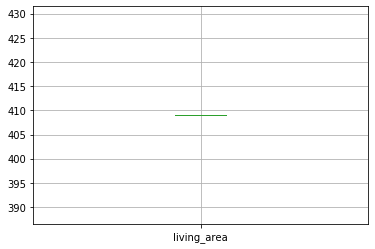

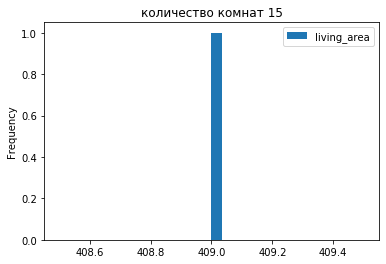

Значения  межквартильного  размаха Q1:409.0 и Q3:409.0
Количество значений за пределами: 0. Общее количество квартир с 15 комнатами: 1
Перцентиль 5% 409.0, а 95% перцентиль равен 409.0


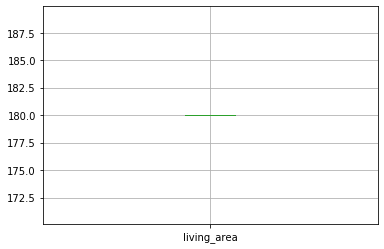

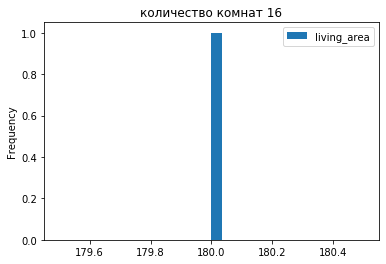

Значения  межквартильного  размаха Q1:180.0 и Q3:180.0
Количество значений за пределами: 0. Общее количество квартир с 16 комнатами: 1
Перцентиль 5% 180.0, а 95% перцентиль равен 180.0


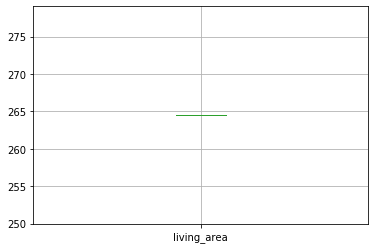

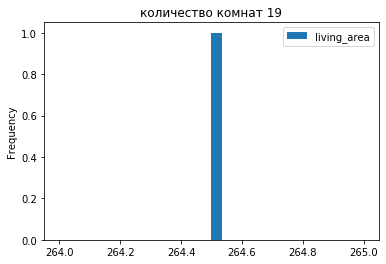

Значения  межквартильного  размаха Q1:264.5 и Q3:264.5
Количество значений за пределами: 0. Общее количество квартир с 19 комнатами: 1
Перцентиль 5% 264.5, а 95% перцентиль равен 264.5
Общее количество заменяемых значений:  717
(22982, 22)


In [16]:
count =0
_dict = {}
for rooms, group_data in data.groupby('rooms'):
    group_data.boxplot(column = 'living_area')   
    #plt.ylim(1, 5)
    plt.show()
    group_data.plot(y="living_area",title='количество комнат '+str(rooms),kind='hist', bins=30)
    plt.show()
    dict_current_room = qantile_calc(group_data)
    stat_list = dict_current_room.get('living_area')
    print('Значения  межквартильного  размаха Q1:{} и Q3:{}'.format(stat_list[3],stat_list[4]))
    _current_room_df = group_data[(group_data.living_area < stat_list[3])|(group_data.living_area > stat_list[4])].copy()
    value_quantity_current_room = _current_room_df.shape[0]
    _dict['Комнат '+str(rooms)] = value_quantity_current_room
    count += value_quantity_current_room
    print('Количество значений за пределами: {}. Общее количество квартир с {} комнатами: {}'
          .format(value_quantity_current_room,rooms, group_data.shape[0]))
    #для самопроверки посмотрим прецентили, сравним их с межквартильным размахом
    percentile5 = group_data.living_area.quantile(.05)
    percentile95 = group_data.living_area.quantile(.95)
    print('Перцентиль 5% {}, а 95% перцентиль равен {}'.format(percentile5,percentile95))
    #удалим строки за пределом межквартильного размаха 
    data = data.loc[~data.index.isin(_current_room_df.index)]
        
print('Общее количество заменяемых значений: ',count)
print(data.shape)
#заполним значения NaN медианными значениями по квартирам с количеством комнат
data['living_area'] = data['living_area'].fillna(data.groupby('rooms')['living_area'].transform('median'))
#print(_dict)

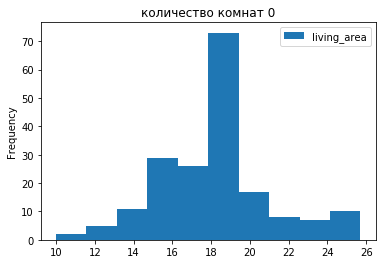

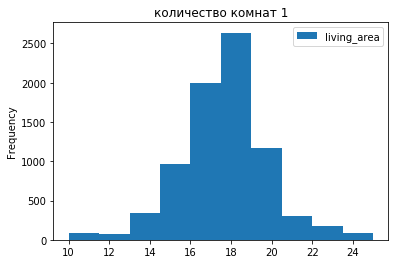

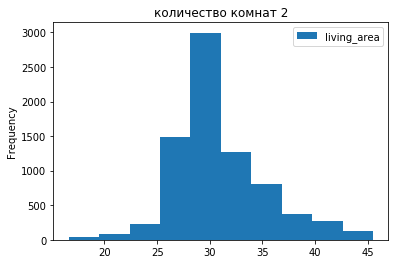

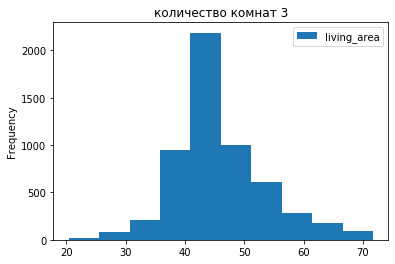

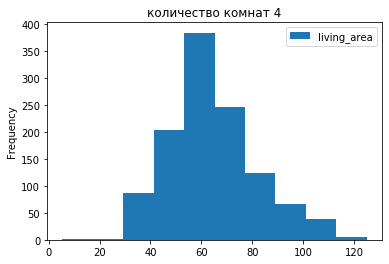

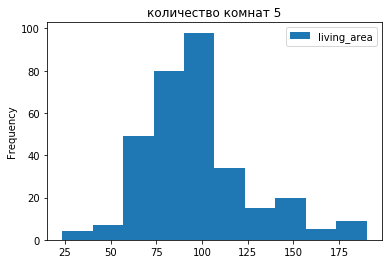

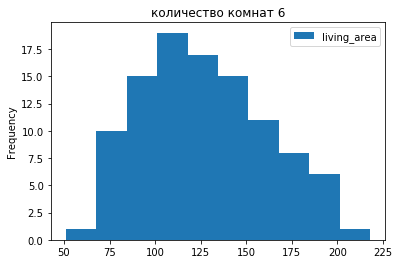

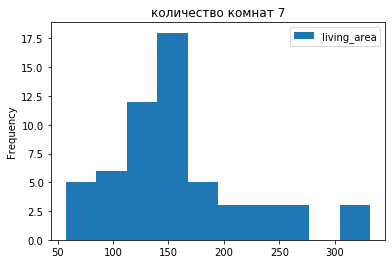

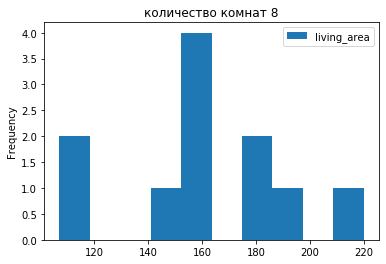

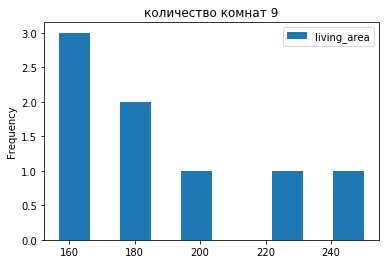

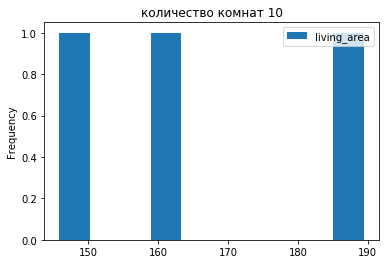

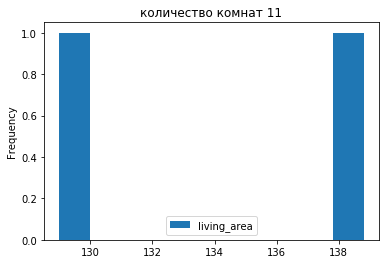

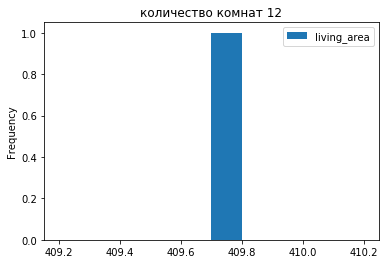

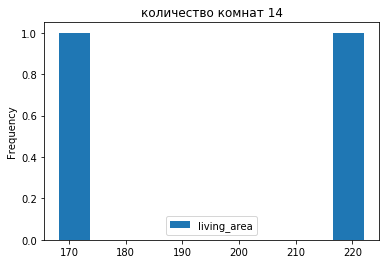

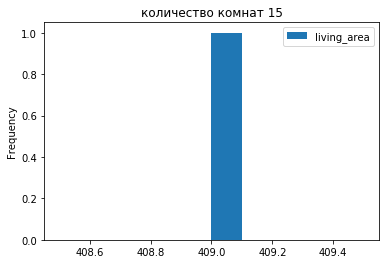

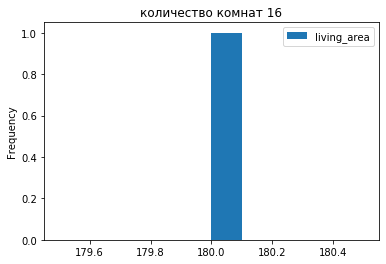

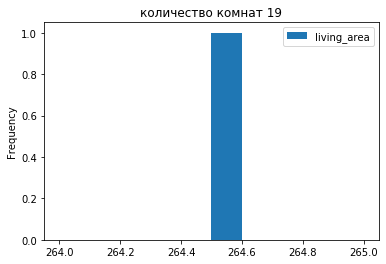

In [17]:
#проверим что значения збыли заполнены корректно
for _room in np.sort(data['rooms'].unique()):
    data.query('rooms==@_room').plot(y="living_area",title='количество комнат '+str(_room),kind='hist', bins=10)
    plt.show()
   


-Проанализировав статистические данные [25%,50%,75%,Q1,Q3]  по __living_area'__: [18.59375, 30.0, 42.3125, -16.98, 77.89]
-видим, что обрезать выбросы по межквартильным размахам не имеет смысла. Возможно группировка по комнатам принесет нам инсайты.
-Сгруппировали данные по количеству комнат и получили следующие параметры: количество квартир, медианные значения по общей площади, жилой площади и площади кухни. Была идея вычесть из общей полощади  площать кухни и некоторую константу, но это будет не совсем правильно. Пока решили оставить данные как есть, чтобы не создавать искуственно шумы.
-Решили поискать выбросы, пользуясь  статистичким приемом как интерквартильный размах Q1 - 2*IQR, Q3 + 2*IQR), где IQR = Q3 - Q1 — интерквартильный размах.(мы сознательно немного увеличили его, чтобы не удалять много данных данные) По каждому срезу  получили количество квартир, которые выходят за пределы интерквартильного размаха, т.е. являются выбросами:
- 'Комнат 0': 9
- 'Комнат 1': 222
- 'Комнат 2': 259
- 'Комнат 3': 195
-  'Комнат 4': 23 
-  'Комнат 5': 5
-  'Комнат 6': 2
-  'Комнат 7': 1
- 'Комнат 8': 1
- 'Комнат 9': 0
- 'Комнат 10': 0
- 'Комнат 11': 0
- 'Комнат 12': 0
- 'Комнат 14': 0
- 'Комнат 15': 0
- 'Комнат 16': 0
- 'Комнат 19': 0
Как мы видим интерквантильные размахи, больше "привязяны" к выборке чем прецентили. Перцентили 5% и 95% тоже хороши при удалении выбросов, но воспользуемся ими в других случаях, они дают схожий результат.
Всего 717 кандидатов на выброс. Но если посмотреть на данные - это могут быть реальные квартиры. Возможно хозяева делали перепланировки или к примеру таунхаусы и элитная недвижимость.
Мы приняли решение удалить необычные объекты, т.к. они будут искажать общую картину.

__Что решили по данному столбцу__: удалить 717 значений снажужи "усов" - (интерквартильного размаха ) и заполнить NaN по медианам `living_area` , полученными после группировки по столбцу `rooms`



,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11575,9,9900000,101.0,2016-04-28T00:00:00,3,2.65,33.0,53.0,32,False,...,21.0,0.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,53.0
18218,4,9900000,101.0,2018-09-27T00:00:00,3,2.65,35.0,53.4,33,NaN,...,13.7,2.0,Санкт-Петербург,18737.0,20450.0,0.0,NaN,3.0,72.0,7.0
18629,20,5700000,54.0,2017-12-08T00:00:00,1,2.65,35.0,21.0,31,NaN,...,18.0,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,128.0


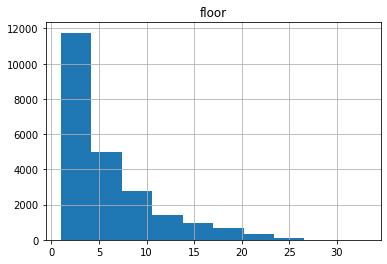

In [18]:
data.hist('floor')
display(data[data.floor > 30])

Пока аномалий не видно, максимальное количество этажей -35, вполне правдоподобно.

In [19]:
#посмотрим сколько объектов с апартаментами
print(data.is_apartment.value_counts())
display(data['is_apartment'].isna().sum())
data.is_apartment.fillna(0,inplace = True)
data.head()

False    2616
True       40
Name: is_apartment, dtype: int64


20326

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,0,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,0,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,0,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159.0,2015-07-24T00:00:00,3,2.65,14.0,44.5,9,0,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,0,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


В выборке по столбцу `is_apartment` 20033 пропущенных значений. Пользователи просто не обращали внимание на дополнительное поле. Заполним его нулевыми значениями.
У нас получилось всего 38 объектов явлвяются апартаментами. Что вполне логично, жилья данного типа еще мало.

In [20]:
print(data.studio.value_counts())
print(len(data))
display(data['studio'].isna().sum())
ratio = (data.studio.value_counts()[1] / len(data)).round(3)
print('Количество студий равно {:.1%}'.format(ratio))

False    22844
True       138
Name: studio, dtype: int64
22982


0

Количество студий равно 0.6%


В выборке 138 студий, что составляет 0.6% от общего значения. Похоже в нашей стране еще много старого фонда.

In [21]:
print(data.open_plan.value_counts())
display(data['open_plan'].isna().sum())

False    22916
True        66
Name: open_plan, dtype: int64


0

Квартир с открытой планировкой всего 66, пропущенных значений нет.

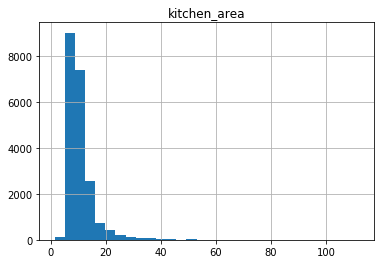

(22982, 22)
Перцентиль для квартир с количеством 0 комнат для 1% равен nan, а 99% перцентиль равен nan
Перцентиль для квартир с количеством 1 комнат для 1% равен 5.0, а 99% перцентиль равен 20.06160000000001
Перцентиль для квартир с количеством 2 комнат для 1% равен 5.0, а 99% перцентиль равен 30.0
Перцентиль для квартир с количеством 3 комнат для 1% равен 5.0, а 99% перцентиль равен 38.0
Перцентиль для квартир с количеством 4 комнат для 1% равен 5.1, а 99% перцентиль равен 46.0
Перцентиль для квартир с количеством 5 комнат для 1% равен 6.737, а 99% перцентиль равен 62.20999999999998
Перцентиль для квартир с количеством 6 комнат для 1% равен 8.25, а 99% перцентиль равен 42.48000000000002
Перцентиль для квартир с количеством 7 комнат для 1% равен 7.0, а 99% перцентиль равен 65.0
Перцентиль для квартир с количеством 8 комнат для 1% равен 5.154, а 99% перцентиль равен 39.257999999999996
Перцентиль для квартир с количеством 9 комнат для 1% равен 11.741999999999999, а 99% перцентиль равен 4

In [22]:
#оценим распределение по кв. метрам на кухне
data.hist('kitchen_area', bins=30)
plt.show()
count =0
print(data.shape)
# Отрежем только явные хвосты, доверительный интервал возьмем 1%
for rooms, group_data in data.groupby('rooms'):
    percentile5 = group_data.kitchen_area.quantile(.01)
    percentile95 = group_data.kitchen_area.quantile(.99)
    print('Перцентиль для квартир с количеством {} комнат для 1% равен {}, а 99% перцентиль равен {}'.format(rooms,percentile5,percentile95))
    _current_room_df = group_data[(group_data.kitchen_area < percentile5)|(group_data.kitchen_area > percentile95)].copy()
    #display(_current_room_df)
    value_quantity_current_room = _current_room_df.shape[0]
    #_dict['Комнат '+str(rooms)] = value_quantity_current_room
    count += value_quantity_current_room
    data = data.loc[~data.index.isin(_current_room_df.index)]
    
print()
print('Всего удалено {} строк, общее количество записей в выборке осталось {}'.format(count,data.shape[0]))    



In [23]:
#возможно это не лучший вариант, но заполним медианным значением, полученным при группировке комнат
print('Количество данных с пропусками равно {}'.format(data[data['kitchen_area'].isna()].shape[0]))
data['kitchen_area'] = data['kitchen_area'].fillna(data.groupby('rooms')['kitchen_area'].transform('median'))
print('Количество данных с пропусками равно {}'.format(data[data['kitchen_area'].isna()].shape[0]))


Количество данных с пропусками равно 2224
Количество данных с пропусками равно 188


Данные жалко - отрежем только явные хвосты. Возьмем прецентили 1% и 99% и сгруппируем по количеству комнат. В итоге получилось 327 строк - удалим их.
Не хватило смелости поставить прецентили больше, т.к. возможно и дальше придется удалять данные по разным причинам.

Возможно - не лучший вариант, но заполним медианным значением, полученным при группировке комнат.Количество Nan до заполнения было ???? после осталось 188, т.к. у студий нет кухни и мы не можем заполнить пропуски. 

[nan  2.  0.  1.  5.  4.  3.]
Количество данных с пропусками равно 10988
Количество данных с балконами больше 3 равно 456


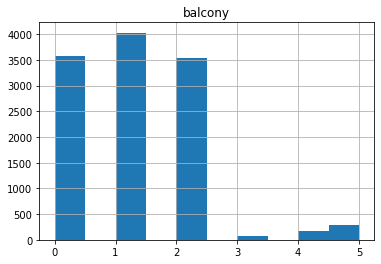

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
41,16,7900000,74.00,2016-05-04T00:00:00,3,2.65,14.0,59.0,8,False,...,12.0,5.0,Санкт-Петербург,37715.0,12612.0,1.0,725.0,1.0,759.0,179.0
42,13,22000000,161.80,2015-07-08T00:00:00,4,2.80,4.0,80.9,2,False,...,17.6,5.0,Петергоф,35416.0,30605.0,2.0,47.0,1.0,907.0,987.0
116,18,10999000,97.20,2017-11-13T00:00:00,3,2.50,16.0,44.5,16,0,...,18.3,5.0,Санкт-Петербург,19426.0,21138.0,0.0,NaN,2.0,390.0,394.0
250,13,3200000,51.70,2019-01-22T00:00:00,2,2.65,16.0,29.2,5,0,...,7.7,4.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,21.0
267,2,14700000,120.00,2018-09-07T00:00:00,3,2.75,20.0,63.0,18,0,...,16.0,5.0,Санкт-Петербург,39204.0,10430.0,2.0,627.0,3.0,77.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23289,13,7000000,88.00,2018-03-02T00:00:00,3,2.50,15.0,54.0,12,False,...,12.0,5.0,Колпино,24501.0,30287.0,1.0,372.0,0.0,NaN,NaN
23474,16,5900000,40.50,2019-03-16T00:00:00,2,2.73,17.0,31.0,16,0,...,5.0,4.0,Санкт-Петербург,19901.0,21613.0,0.0,NaN,1.0,1003.0,NaN
23497,17,6150000,55.40,2019-04-22T00:00:00,2,2.80,20.0,29.4,16,0,...,9.6,4.0,Санкт-Петербург,16285.0,13873.0,0.0,NaN,1.0,481.0,NaN
23526,14,5800000,60.69,2018-03-13T00:00:00,3,2.50,9.0,39.7,2,0,...,6.2,5.0,Санкт-Петербург,51239.0,15954.0,0.0,NaN,0.0,NaN,30.0


Количество данных с пропусками равно 0


In [24]:
print(data['balcony'].unique())
print('Количество данных с пропусками равно {}'.format(data[data['balcony'].isna()].shape[0]))
print('Количество данных с балконами больше 3 равно {}'.format(data[data['balcony']>3].shape[0]))
data.hist('balcony')
plt.show()
display(data[data['balcony']>3])
data['balcony'] = data['balcony'].fillna(0)
print('Количество данных с пропусками равно {}'.format(data[data['balcony'].isna()].shape[0]))

Если человек не указал число балконов — скорее всего, их нет. Такие пропуски замениm на 0..
Заметим, что количество квартир с 4 и 5 балконами составляет 456, что немного странно. 
Неужели это все элитная недвижимость? Или при заполнения объявления пользователь допустил ошибку? Нужно будет выяснить позже.



In [25]:
display(data['locality_name'].value_counts()[0:50])


Санкт-Петербург                            14908
посёлок Мурино                               511
посёлок Шушары                               430
Всеволожск                                   388
Пушкин                                       345
Колпино                                      331
посёлок Парголово                            324
Гатчина                                      296
деревня Кудрово                              287
Выборг                                       228
Петергоф                                     197
Сестрорецк                                   175
Красное Село                                 174
Кудрово                                      168
Сертолово                                    141
деревня Новое Девяткино                      137
Ломоносов                                    128
Кириши                                       123
Сланцы                                       110
Волхов                                       107
Тосно               

In [26]:
#Удалим строки с пропущенными городами
#data.dropna(subset = ['locality_name'], inplace = True)


К сожалению пропущенные 49 значений столбца мы заполнить не сможем, т.к. не можем найти обоснования для заполнения одним из существующих значений, взятым из других строк. Поэтому оставим этот столбцец как есть.


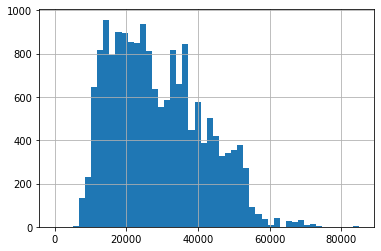

37434.0    53
21928.0    32
39140.0    26
39946.0    26
18732.0    26
44870.0    24
47303.0    23
21793.0    23
37412.0    23
31744.0    22
51333.0    22
30073.0    21
21460.0    21
19499.0    21
22041.0    21
44382.0    21
37407.0    20
13461.0    20
23639.0    20
43074.0    19
Name: airports_nearest, dtype: int64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21085,0,7000000,34.7,2018-09-23T00:00:00,1,2.7,9.0,19.8,3,0,...,6.0,2.0,Санкт-Петербург,0.0,22801.0,0.0,NaN,0.0,NaN,60.0


In [27]:

data['airports_nearest'].hist(bins=50)
plt.show()
print(data['airports_nearest'].value_counts().head(20))
display(data.query('airports_nearest<5000'))



Распределение больше похоже на пуассновское. В Целом данные в выборке адекватные - основное количество квартир от находится на расстоянии от 10 до 60 километров от аэропорта. Выбросов тоже скорее всего нет т.к. 80-90 км. (это хвост выборки) тоже лен область и там люди тоже хотят продать жилье.
Вывели топ по уникльным значениям, чтобы посмотреть небыло ли технической ошибке. Вроде все нормально, идем дальше
Нашли одну квартиру, которая прямо в аэропорту, скорее всего ошибочно завели адрес при подаче объявления.

5368


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
577,7,4000000,59.0,2017-07-23T00:00:00,3,2.50,5.0,37.0,1,False,...,7.0,0.0,посёлок Молодёжное,84665.0,65764.0,0.0,NaN,0.0,NaN,NaN
2974,13,3200000,46.3,2018-03-31T00:00:00,2,2.50,3.0,29.2,2,0,...,7.0,1.0,Зеленогорск,81355.0,62454.0,0.0,NaN,0.0,NaN,205.0
5218,15,3650000,53.8,2018-09-24T00:00:00,3,2.50,4.0,36.9,3,0,...,5.2,0.0,посёлок Молодёжное,83758.0,64857.0,0.0,NaN,0.0,NaN,121.0
5340,19,3600000,50.6,2019-03-19T00:00:00,2,2.50,5.0,29.9,4,0,...,7.0,1.0,посёлок Молодёжное,84853.0,65952.0,0.0,NaN,0.0,NaN,NaN
9640,8,4200000,51.4,2014-12-10T00:00:00,2,2.55,5.0,31.0,2,0,...,6.0,1.0,посёлок Молодёжное,84869.0,65968.0,0.0,NaN,0.0,NaN,1194.0
16569,13,3200000,52.8,2017-06-20T00:00:00,2,2.55,5.0,29.9,3,0,...,8.3,0.0,Ломоносов,53042.0,61495.0,2.0,223.0,0.0,NaN,240.0
18884,15,3600000,57.6,2019-02-08T00:00:00,3,2.55,3.0,41.3,2,0,...,6.5,1.0,Зеленогорск,81607.0,62706.0,0.0,NaN,0.0,NaN,13.0
20746,1,3300000,43.5,2016-02-16T00:00:00,2,2.55,4.0,27.2,2,0,...,5.0,1.0,посёлок Молодёжное,84006.0,65105.0,0.0,NaN,0.0,NaN,1043.0
23123,0,1800000,32.0,2018-07-17T00:00:00,1,2.65,2.0,17.0,1,0,...,6.0,0.0,Ломоносов,56896.0,60223.0,1.0,17.0,0.0,NaN,147.0


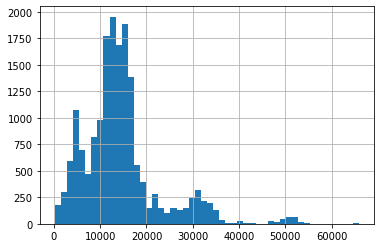

In [28]:
data['cityCenters_nearest'].hist(bins=50)
print(data.cityCenters_nearest.isnull().sum())
display(data.query('cityCenters_nearest>60000'))

In [29]:
data['cityCenters_nearest'].fillna(0,inplace=True)
display(data[data['cityCenters_nearest']!=data['cityCenters_nearest']])


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


В столбце имеются 5368 пропусков, но без дополнительных данных о геолокации мы их заполнить не сможем.
В целом, распределение похоже на нормальное, "толстый хвост" объясняется населенными пунктами - спутниками,где тоже живут люди.
-  выбросов нет, то что выше 60 километров - реальные данные.

In [30]:
print(data['parks_around3000'].value_counts().head(20))
display(data['parks_around3000'].isna().sum())
#Насселенный пункт, где есть расстояние до парка
print(data.query('~parks_around3000.isnull()',engine='python')['locality_name'].value_counts().head(20))
#Насселенный пункт, где нет расстояния до парка
print(data.query('parks_around3000.isnull()',engine='python')['locality_name'].value_counts().head(20))

0.0    9749
1.0    5382
2.0    1584
3.0     572
Name: parks_around3000, dtype: int64


5367

Санкт-Петербург            14853
посёлок Шушары               427
Пушкин                       345
Колпино                      330
посёлок Парголово            324
Петергоф                     197
Сестрорецк                   175
Красное Село                 172
Ломоносов                    127
Кронштадт                     88
посёлок Металлострой          65
посёлок Стрельна              38
Павловск                      37
Зеленогорск                   22
посёлок Понтонный             20
посёлок Сапёрный               6
посёлок Молодёжное             5
посёлок Репино                 3
посёлок Александровская        2
посёлок Лисий Нос              2
Name: locality_name, dtype: int64
посёлок Мурино             511
Всеволожск                 388
Гатчина                    296
деревня Кудрово            287
Выборг                     228
Кудрово                    168
Сертолово                  141
деревня Новое Девяткино    137
Кириши                     123
Сланцы                     

Количество квартир без парков в радиусе 3 км 9885, что сомнительно может не все парки считали? Так же есть 5367 пропущенных значений,
если не была обозначена локация объекта, значит и нельзя посчитать расстояние.

In [31]:
print(data['parks_nearest'].value_counts().head(20))
display(data['parks_nearest'].isna().sum())
#в каких населенных пунктах есть информация по паркам
print(data.query('~parks_nearest.isnull()',engine='python')['locality_name'].value_counts())
# а в какх ее нет
print(data.query('parks_nearest.isnull()',engine='python')['locality_name'].value_counts().head(20))

441.0     59
173.0     40
392.0     39
456.0     31
471.0     29
541.0     28
447.0     28
458.0     27
485.0     27
288.0     26
2102.0    26
367.0     25
537.0     25
570.0     24
401.0     24
315.0     23
223.0     23
674.0     22
679.0     22
309.0     22
Name: parks_nearest, dtype: int64


15112

Санкт-Петербург      6785
Пушкин                198
Петергоф              141
Колпино               129
Кронштадт              80
Сестрорецк             68
Красное Село           45
Павловск               25
посёлок Стрельна       19
Ломоносов              14
Зеленогорск            14
посёлок Парголово      10
Name: locality_name, dtype: int64
Санкт-Петербург            8123
посёлок Мурино              511
посёлок Шушары              430
Всеволожск                  388
посёлок Парголово           314
Гатчина                     296
деревня Кудрово             287
Выборг                      228
Колпино                     202
Кудрово                     168
Пушкин                      147
Сертолово                   141
деревня Новое Девяткино     137
Красное Село                129
Кириши                      123
Ломоносов                   114
Сланцы                      110
Сестрорецк                  107
Волхов                      107
Тосно                       103
Name: locality

Ошибки в обработке данных нет. Отсутствуют уникальные знаения, которые попавдаются на множестве строк. Большое количество пропусков 15112, намного болше чем в `parks_around3000`. Не знаю чем можно объяснить, т.к. если бы была геолокация - то посчитать расстояние - не проблема.


0.0    8751
1.0    5452
2.0    1781
3.0    1303
Name: ponds_around3000, dtype: int64


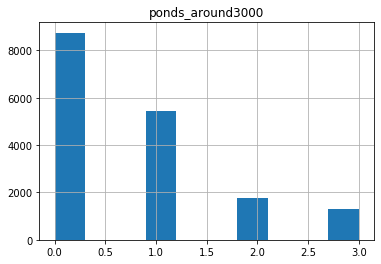

5367

In [32]:
print(data['ponds_around3000'].value_counts().head(20))
data.hist('ponds_around3000')
plt.show()
display(data['ponds_around3000'].isna().sum())


По количеству водоемов до 3 км. пропущенные значения совпадают по количеству парков до 3 км.

In [33]:
print(data['ponds_nearest'].value_counts().head(20))
display(data['ponds_nearest'].isna().sum())
#Насселенный пункт, где есть расстояние до парка
print(data.query('~ponds_nearest.isnull()',engine='python')['locality_name'].value_counts().head(20))
#Насселенный пункт, где нет расстояния до парка
print(data.query('ponds_nearest.isnull()',engine='python')['locality_name'].value_counts().head(20))

427.0    62
433.0    38
153.0    37
474.0    35
564.0    34
454.0    34
303.0    32
440.0    31
359.0    30
400.0    29
733.0    29
374.0    28
756.0    28
196.0    27
274.0    27
80.0     27
136.0    27
170.0    26
429.0    26
399.0    25
Name: ponds_nearest, dtype: int64


14118

Санкт-Петербург            7460
Колпино                     186
Пушкин                      161
посёлок Шушары              149
Сестрорецк                  128
Петергоф                    114
Кронштадт                    80
Ломоносов                    80
посёлок Парголово            55
Павловск                     33
посёлок Стрельна             20
Зеленогорск                  16
Красное Село                 10
посёлок Понтонный             7
посёлок Сапёрный              6
поселок Мурино                2
посёлок Александровская       2
посёлок Белоостров            1
посёлок Петро-Славянка        1
Name: locality_name, dtype: int64
Санкт-Петербург            7448
посёлок Мурино              511
Всеволожск                  388
Гатчина                     296
деревня Кудрово             287
посёлок Шушары              281
посёлок Парголово           269
Выборг                      228
Пушкин                      184
Кудрово                     168
Красное Село                164
Колпин

Пропущено 14118 значений, что очень существенно. Вывели посмотреть населенный пункты по которым есть/пропущены значения. По СПБ примерно картина одинаковая, а вот вне города пропущенных значений намного больше - то ли там нет водоемов, толи никто их не мог/не захотел посчитать.

45.0    866
60.0    526
7.0     223
30.0    199
90.0    190
4.0     171
3.0     152
5.0     145
14.0    140
20.0    136
Name: days_exposition, dtype: int64


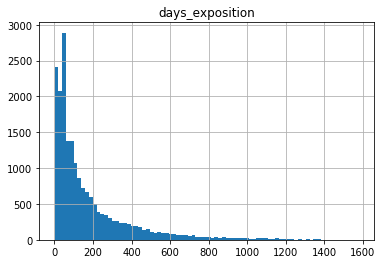

Int64Index([2, 3, 1, 4, 5, 6, 7, 0, 9, 8], dtype='int64') Int64Index([2, 3, 1, 4, 5, 6, 7, 0, 9, 8], dtype='int64')


,quantity_room,days_exposition_null,ratio
7,56,22.0,0.392857
9,6,2.0,0.333333
6,101,28.0,0.277228
5,315,72.0,0.228571
4,1138,229.0,0.201230
3,5556,938.0,0.168826
2,7575,940.0,0.124092
8,9,1.0,0.111111
1,7705,728.0,0.094484
0,188,13.0,0.069149


In [34]:
print(data.days_exposition.value_counts().head(10))
data.hist('days_exposition',bins=80)
plt.show()
_d1 = (data.query('days_exposition.isnull()',engine='python')['rooms'].value_counts().head(20))
_d2 = data.rooms.value_counts()
print(_d1.index,_d1.index)
#соберем 2 series в один df
_df = pd.DataFrame(pd.concat([_d2,_d1],axis=1))
_df.columns=['quantity_room','days_exposition_null']
_df['ratio'] = _df.apply(lambda row: row.days_exposition_null/row.quantity_room, axis = 1)
_df.sort_values(by='ratio',inplace=True,ascending=False) 
display(_df)

In [35]:
print(data.query('days_exposition.isnull()',engine='python')['rooms'].value_counts().head(20))
data['first_day_exposition_month'] = pd.DatetimeIndex(data['first_day_exposition']).year
print(data.query('days_exposition.isnull()',engine='python')['first_day_exposition_month'].value_counts().head(20))


2    940
3    938
1    728
4    229
5     72
6     28
7     22
0     13
9      2
8      1
Name: rooms, dtype: int64
2019    1705
2018     893
2017     239
2016      61
2015      60
2014      15
Name: first_day_exposition_month, dtype: int64


- В столбце `days_exposition` 2973 пропущенных значения. Основное количество квартир продавалось за  200 дней, очень информативный показатель, в комбинации с другими столбцами может дать нам понимание что и когда происходило на рынке.
- Попытались прикинуть и найти причину пропусков - заметили что с 2017 года они начали нарастать как снежный ком, возможожно дело в изменениях в системе биллинга, пользователь на этот показатель повлиять не может. 
- Есть интересный момент, что есть связь между пропущенными значениями и количеством комнат. Возможно кто-то неаккуратно переносил данные и удалил их часть. Но на однушках и студиях это сказалось меньше всего, там самый небольшой процент потерь

In [36]:
#осуществим преобразование тпиов данных. 
#После преобразования наши данные будут обрабатываться быстрее 
#и к ним можно будет применить корректные методы, соответствующие их типам
data['total_images'] = data['total_images'].astype('uint8')
data['last_price'] = data['last_price'].astype('float16')
data['total_area'] = data['total_area'].astype('float16')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
data['rooms'] = data['rooms'].astype('uint8')
data['ceiling_height'] = data['ceiling_height'].astype('float16')
data['floors_total'] = data['floors_total'].astype('float16')
data['living_area'] = data['living_area'].astype('float16')
data['floor'] = data['floor'].astype('uint8')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['kitchen_area'] = data['kitchen_area'].astype('float16')
data['balcony'] = data['balcony'].astype('bool')
data['locality_name'] = data['locality_name'].astype('category')                                                               
data['airports_nearest'] = data['airports_nearest'].astype('float16')
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('float16')
data['parks_around3000'] = data['parks_around3000'].astype('float16')
data['parks_nearest'] = data['parks_nearest'].astype('float16')
data['ponds_around3000'] = data['ponds_around3000'].astype('float16')                                                               
data['ponds_nearest'] = data['ponds_nearest'].astype('float16')
data['days_exposition'] = data['days_exposition'].astype('float16')



[в начало](#toc)

In [37]:
data.isnull().sum()

total_images                      0
last_price                        0
total_area                        0
first_day_exposition              0
rooms                             0
ceiling_height                    0
floors_total                     84
living_area                       0
floor                             0
is_apartment                      0
studio                            0
open_plan                         0
kitchen_area                    188
balcony                           0
locality_name                    45
airports_nearest               5385
cityCenters_nearest               0
parks_around3000               5367
parks_nearest                 15112
ponds_around3000               5367
ponds_nearest                 14118
days_exposition                2973
first_day_exposition_month        0
dtype: int64

In [38]:
data.dtypes

total_images                           uint8
last_price                           float16
total_area                           float16
first_day_exposition          datetime64[ns]
rooms                                  uint8
ceiling_height                       float16
floors_total                         float16
living_area                          float16
floor                                  uint8
is_apartment                            bool
studio                                  bool
open_plan                               bool
kitchen_area                         float16
balcony                                 bool
locality_name                       category
airports_nearest                     float16
cityCenters_nearest                  float16
parks_around3000                     float16
parks_nearest                        float16
ponds_around3000                     float16
ponds_nearest                        float16
days_exposition                      float16
first_day_

### Шаг 3. Посчитайте и добавьте в таблицу<a id="35"></a>

In [39]:
#посчитаем цену квадратного метра
data['sq_m_price'] = data['last_price']/data['total_area']
#вычислим день недели, месяц и год публикации объявления;
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
#Создадим дополнительную категорию для анализа жилья с первыми и последними этажами
def level_flat(raw):
    if raw['floor'] == 1:
        return 'Первый'
    elif raw['floor'] == raw['floors_total']:
        return 'Последний'
    return 'Другой'
data['level_flat'] = data.apply(level_flat,axis=1)  

#найдем отношение жилой площади к общей
data['living_to_total'] = data['living_area']/data['total_area']
#площади кухни к общей
data['kitchen_to_total'] = data['kitchen_area']/data['total_area']
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,first_day_exposition_month,sq_m_price,weekday,month,year,level_flat,living_to_total,kitchen_to_total
0,20,inf,108.00000,2019-03-07,3,2.699219,16.0,51.000000,8,False,...,755.0,NaN,2019,inf,3,3,2019,Другой,0.472168,0.231445
1,7,inf,40.40625,2018-12-04,1,2.650391,11.0,18.593750,1,False,...,NaN,81.0,2018,inf,1,12,2018,Первый,0.460205,0.272217
2,10,inf,56.00000,2015-08-20,2,2.650391,5.0,34.312500,4,False,...,574.0,558.0,2015,inf,3,8,2015,Другой,0.612793,0.148193
3,0,inf,159.00000,2015-07-24,3,2.650391,14.0,44.500000,9,False,...,234.0,424.0,2015,inf,4,7,2015,Другой,0.279785,0.057892
5,10,inf,30.40625,2018-09-10,1,2.650391,12.0,14.398438,5,False,...,NaN,55.0,2018,inf,0,9,2018,Другой,0.473633,0.299316


На основании существующих данных мы создали дополнительные метрики:
- посчитали стоимость квадратного метра
- вычислили отношение жилой площади к общей, площади кухни к общей
- категоризировали данные по этажам, выделив первый и последний этажи.

[в начало](#toc)

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:<a id="45"></a>

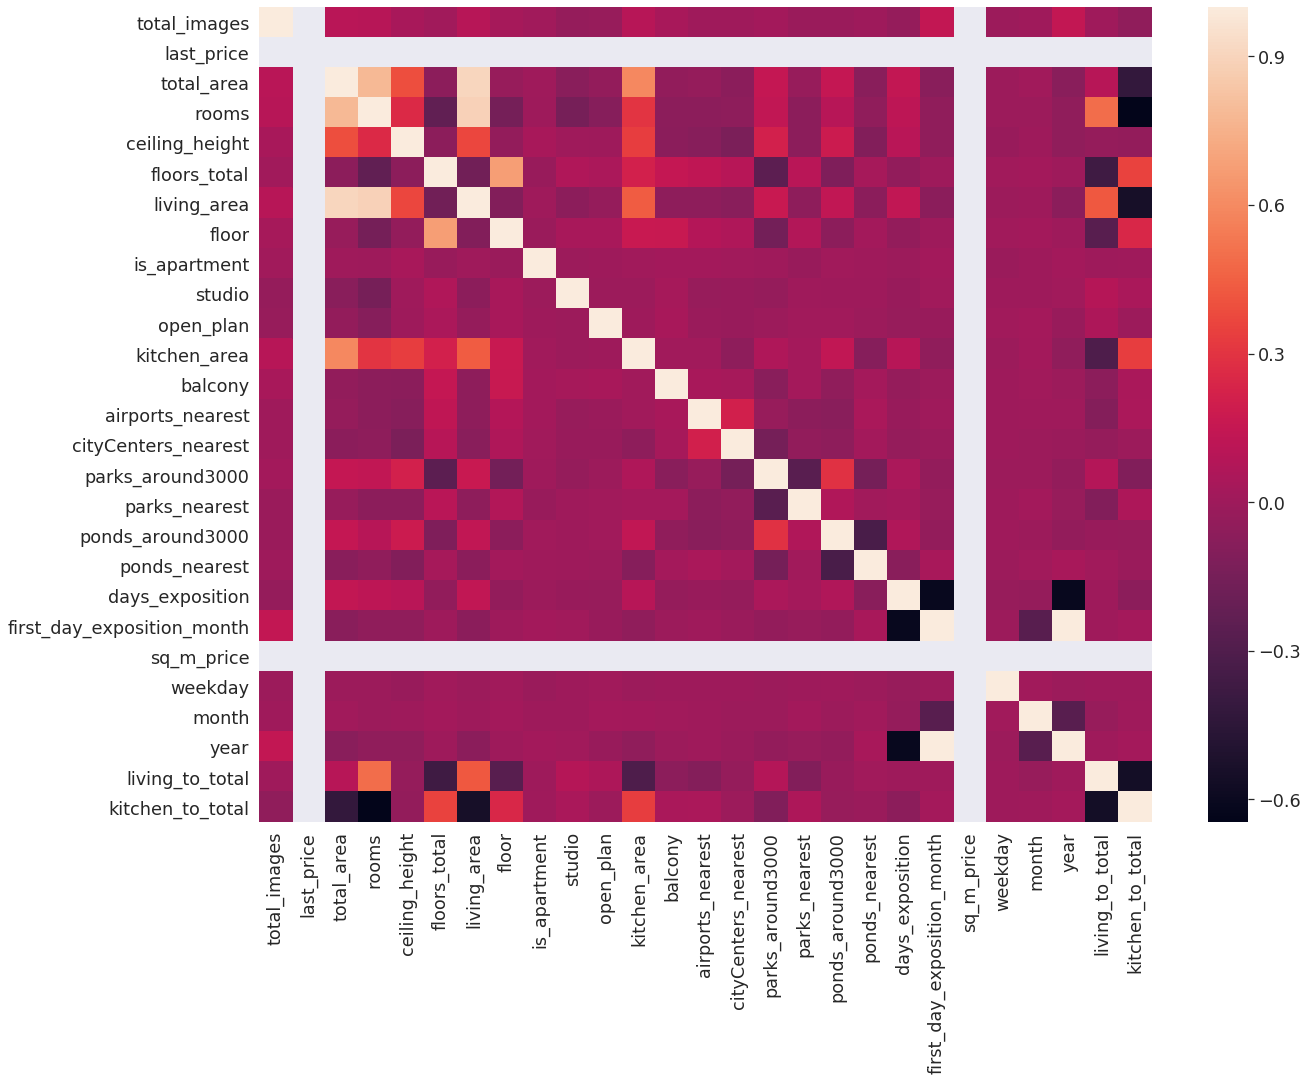

In [40]:
# закомментировал, т.к сбиваются другие графики после этой карты
#Посмотрим корреляции на тепловой карте после фильтрации 

corr =data.corr()
# увеличиваем размер текста и карты
sns.set(font_scale=1.6)
plt.subplots(figsize=(20,15))
# #строим тепловую карту
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );
# plt.subplots(figsize=(8,6))
sns.heatmap(corr)

<div class="alert alert-block alert-success">
    
Ты опять перемудрил) смотри - у нас очень много параметров и выводить их на хитмаппу вместе с числами нерационально- картинка будет слишкмо грязной. В идеале оставить только явно коррелирующие столбцы, или убрать числа, как я сделал выше.
    
Вообще все проблемы уйдут, если смотреть документацию по используемым функциям (http://seaborn.pydata.org/generated/seaborn.heatmap.html)
    

In [41]:
corr_table = data.corr().unstack().sort_values(kind="quicksort",ascending=False)
#топ 15 по положиетельным корреляциями
print( corr_table[27:57])
#топ 15 по отридцательным корреляциям
display( corr_table[-30:])

total_area        living_area         0.905736
living_area       total_area          0.905736
                  rooms               0.889438
rooms             living_area         0.889438
                  total_area          0.784652
total_area        rooms               0.784652
floor             floors_total        0.675326
floors_total      floor               0.675326
kitchen_area      total_area          0.590606
total_area        kitchen_area        0.590606
living_to_total   rooms               0.492215
rooms             living_to_total     0.492215
living_area       kitchen_area        0.435147
kitchen_area      living_area         0.435147
living_to_total   living_area         0.422187
living_area       living_to_total     0.422187
total_area        ceiling_height      0.391514
ceiling_height    total_area          0.391514
living_area       ceiling_height      0.365734
ceiling_height    living_area         0.365734
floors_total      kitchen_to_total    0.354532
kitchen_to_to

sq_m_price        floor                        NaN
                  is_apartment                 NaN
                  studio                       NaN
                  open_plan                    NaN
                  kitchen_area                 NaN
                  balcony                      NaN
                  airports_nearest             NaN
                  cityCenters_nearest          NaN
                  parks_around3000             NaN
                  parks_nearest                NaN
                  ponds_around3000             NaN
                  ponds_nearest                NaN
                  days_exposition              NaN
                  first_day_exposition_month   NaN
                  sq_m_price                   NaN
                  weekday                      NaN
                  month                        NaN
                  year                         NaN
                  living_to_total              NaN
                  kitchen_to_to

Есть корреляции которые объяснимы, попробуем посмотреть положительные и отридцательные корреляции на первый взгляд не связанных параметров
#### Положительные
-чем больше высота потолка, тем выше цена 0.39

#### Отридцательные:
- чем больше год, тем меньше время продажи квартиры (это интересно, можно будет попробовать построить график) -0.6
- Корреляция между временем продажи и месяцем отридцательная (тут мутация данных, т.к. номер месяца категориальное значение) -0.6
- Между отношением жилой площади и количеством этажей (чем ниже этаж тем больше доля жилй площади? интерестно!!!) -0.37

Вообщем анализ корреляции не принес нам много инсайтов, но все же подкинул пару новых идей для дополнительного исследования. Не будем забывать, что корреляция показывает только линейную зависимость


In [43]:
#Изучим следующие параметры: площадь, цена, число комнат, высота потолков. 
#Построем гистограммы для каждого параметра
#data.columns
display(data[['total_area','last_price','rooms','ceiling_height']].describe())
set_columns = {'total_area','last_price','rooms','ceiling_height'}
# plt.subplots(figsize=(20,15))
sns.set(font_scale=1)
for column in set_columns:
    #data.hist(column,bins=20)
    #data.plot(y=column,title=column,kind='hist',bins=15)
    #?у меня как то применились настройки с предыдущего плота, как мне их убрать
    #plt.show()

SyntaxError: unexpected EOF while parsing (<ipython-input-43-4a88a68da47a>, line 12)

In [44]:
data.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,ponds_around3000,ponds_nearest,days_exposition,first_day_exposition_month,sq_m_price,weekday,month,year,living_to_total,kitchen_to_total
total_images,1.000000,NaN,0.105712,0.099257,0.036961,0.012771,0.099771,0.031741,0.011265,-0.029137,...,-0.014863,0.002472,-0.030921,0.142967,NaN,-0.007560,0.007058,0.142967,0.004876,-0.052500
last_price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_area,0.105712,NaN,1.000000,0.784652,0.391514,-0.064322,0.905736,-0.023011,0.009346,-0.078036,...,0.150926,-0.079627,0.143488,-0.073734,NaN,-0.006434,0.010327,-0.073734,0.095012,-0.421975
rooms,0.099257,NaN,0.784652,1.000000,0.258961,-0.230043,0.889438,-0.154243,-0.000587,-0.147065,...,0.094992,-0.052849,0.123785,-0.053138,NaN,-0.004559,-0.003425,-0.053138,0.492215,-0.645538
ceiling_height,0.036961,NaN,0.391514,0.258961,1.000000,-0.063571,0.365734,-0.036980,0.040803,0.004651,...,0.181339,-0.099733,0.106483,-0.053230,NaN,-0.021290,-0.002023,-0.053230,-0.031213,-0.040454
floors_total,0.012771,NaN,-0.064322,-0.230043,-0.063571,1.000000,-0.169868,0.675326,-0.021575,0.071101,...,-0.112797,0.032280,-0.047487,0.003671,NaN,0.011948,0.019598,0.003671,-0.372327,0.354532
living_area,0.099771,NaN,0.905736,0.889438,0.365734,-0.169868,1.000000,-0.104035,0.007382,-0.061309,...,0.136401,-0.068821,0.134898,-0.067343,NaN,-0.008164,0.000887,-0.067343,0.422187,-0.543094
floor,0.031741,NaN,-0.023011,-0.154243,-0.036980,0.675326,-0.104035,1.000000,-0.012677,0.037924,...,-0.066686,0.018583,-0.037532,0.003261,NaN,0.010179,0.022056,0.003261,-0.270726,0.245316
is_apartment,0.011265,NaN,0.009346,-0.000587,0.040803,-0.021575,0.007382,-0.012677,1.000000,-0.003209,...,0.013112,0.005388,-0.008465,0.020661,NaN,-0.010111,-0.002275,0.020661,-0.001864,0.008197
studio,-0.029137,NaN,-0.078036,-0.147065,0.004651,0.071101,-0.061309,0.037924,-0.003209,1.000000,...,-0.000043,-0.000396,-0.021423,0.012860,NaN,-0.002235,0.001656,0.012860,0.090756,0.046016


Значения потолков, начинаются с 2,5 и ограничиваются 3,5 метрами. Вполне логично.
Количество комнат, в основном не больше 5,
По поводу цены - требуется дополнительная аналитика, пока видно что в основном это дешевые квартиры
По общей площади видно что в основном в продаже небольшие квартиры. Квартир с площадью более 150 совсем мало

Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

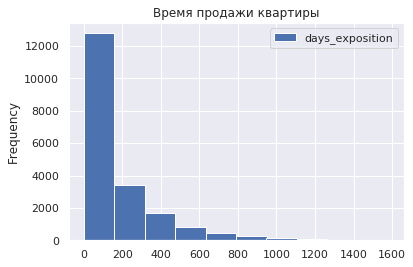

In [45]:
#Изучим время продажи квартиры.
data.plot(y='days_exposition',kind='hist',title='Время продажи квартиры')
#from pandas.plotting import bootstrap_plot
#bootstrap_plot(data[''])

В большинстве своем, основная часть квартир продается за 150 дней.
Редко встречаются квартиры, объявление о которых висит более 2 лет.

In [46]:
data.days_exposition.describe()

count    19681.0
mean         inf
std          inf
min          1.0
25%         45.0
50%         94.0
75%        229.0
max       1580.0
Name: days_exposition, dtype: float64

В среднем на продажу квартиры уходит пол года, медианное значение намного меньше - 3 месяца. 
Значит есть квартиры которые висят на сайте очень долго. Если вы продали квартиру меньше чем за 45 дней -вам повезло, если больше чем за 229 - повод задуматься сбавить цену.

In [47]:
#Для ревьювера
# редкие и выбивающиеся значения описал во 2-й части

•	Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. 

Корреляцияя между общей площадью и ценой равна: nan


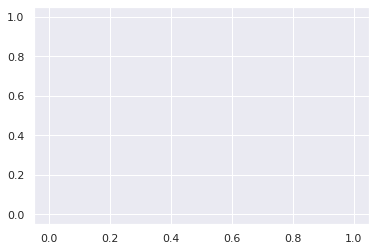

In [48]:
plt.plot(data.total_area, data.last_price, 'g.' )
print('Корреляцияя между общей площадью и ценой равна:',data.total_area.corr( data.last_price).round(2))
plt.show()

In [50]:
#scatter_matrix(data[['total_area', 'last_price','rooms']], alpha=0.5, figsize=(10, 6));
#pd.plotting.scatter_matrix(data[['total_area', 'last_price','rooms','cityCenters_nearest']], figsize=(20, 15))
#xlim=(0,100),ylim=(0,100)

Явно видно что квартир с большой площадью в центре намного больше,
это так же видно и в части увеличения стоимости, хотя не так явно. 
Квартиры с 5 комнатами и более, так же сосредоточены в центре.
Довольно странно что, некоторые 5 комнтаные квартиры равны по общей площади двухкомнатным. 
Ну и у квартир с площадью более 5 комнат идет больше разброс по площади чем у квартир с 4 и меньше.

Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. 
Также изучите зависимость от даты размещения: дня недели, месяца и года.

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning:

invalid value encountered in multiply

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning:

invalid value encountered in multiply

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning:

invalid value encountered in double_scalars



(0, 10000000)

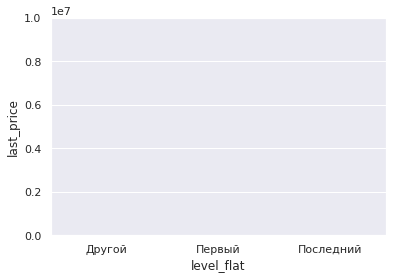

In [51]:
ax = sns.boxplot(x='level_flat', y='last_price', data=data);
ax.set_ylim([0,10000000])

<div class="alert alert-block alert-success">
<b>Success:</b> отличная визуализация

При анализе зависимости цены от того, на каком этаже расположена квартира: первом, последнем или другом. Видно что медианная цена на первом этаже самая низкая, на последнем чуть повыше. 
А в квартирах не на крайних этажах цена еще выше.
    

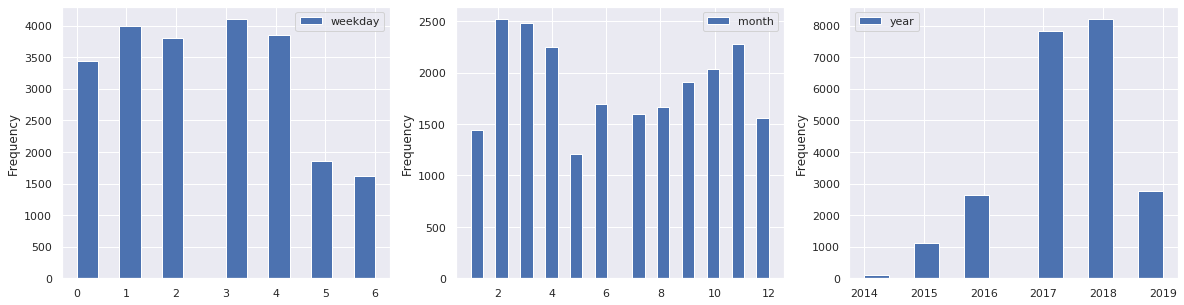

In [52]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
_list_seasons = {'weekday':7, 'month':12, 'year':6}
_count=0
for season,quant in _list_seasons.items():
    #через bar не получается вывести, постоянно виснет, не понимаю как через него сделать
    data.plot(y=season,kind='hist',ax=axes[_count],bins=quant*2)
    _count +=1
plt.show()    

Также изучите зависимость количества размещения объектов от даты размещения: дня недели, месяца и года:
-Почему то в выходные постят в два раза меньше объявлений, чем в будни. Возможно много риэлторов на рынке. По дням рабочей недели в целом ровно, немного проседает понедельник.
-размещение объявлений по месяцам как раз показывает деловую активность в городе. Низкая активность в январе и летние месяцы. Декабрь тоже не лучшее время для покупок, у всех мысли о Новом Годе.
-Количество объявлений по годам ничего не говорит, т.к. популярность данной доски обявлений могла менятся и трудно интерпретировать эти данные. К тому же нужно привести размерности, т.к. за 2014 и за 2019 годы мы имеем данные не за всесь календарных год.

•	Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах.Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.

In [53]:
_top_10_city = data['locality_name'].value_counts()[0:10]
_top_10_city_df = data.query('locality_name in @_top_10_city.index')
print('Процент квартир в первых 10 городах от общей выборки {:.1%}'.format(len(_top_10_city_df)/len(data)))
sq_m_price_10_city = _top_10_city_df['sq_m_price'].mean()

Процент квартир в первых 10 городах от общей выборки 79.7%


In [54]:
data_pivot = _top_10_city_df.copy()
data_pivot = data_pivot.pivot_table(index=['locality_name'], values='sq_m_price', aggfunc=['mean','count'])
data_pivot.set_axis(['mean_sq_m_price','count_sq_m_price'],axis = 'columns', inplace = True)
data_pivot = data_pivot.sort_values(by='mean_sq_m_price',ascending=False)
display(data_pivot.head(10))

,mean_sq_m_price,count_sq_m_price
locality_name,,
Всеволожск,inf,388
Выборг,inf,228
Гатчина,inf,296
Колпино,inf,331
Пушкин,inf,345
Санкт-Петербург,inf,14908
деревня Кудрово,inf,287
посёлок Мурино,inf,511
посёлок Парголово,inf,324


В первых 10 городах продается 79.7% процентов недвижимости от той, что имеется в нашей базе.
Заметим что в Пушкине квартиры стоят почти столько же как в Питере, хотя Кудрово, Мурино и Шушары,
даже ближе к центру. Может все дело в экологии и культурном наследии города?
Колпино, Гатчина, Всеволожск и Выборг - находятся чуть дальше от КАД, поэтому и жилье там стоит дешевле

km_centr
0.000000     inf
0.181000     inf
0.208000     inf
0.215000     inf
0.291000     inf
            ... 
28.639999    inf
28.799999    inf
29.264000    inf
29.344000    inf
29.488001    inf
Name: sq_m_price, Length: 2670, dtype: float32

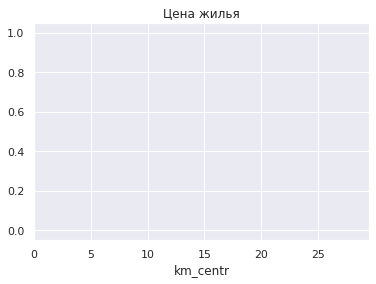

In [55]:
data['km_centr'] = (data['cityCenters_nearest']/1000)
SPB = data.query('locality_name=="Санкт-Петербург"')


km_price_SPB = SPB.pivot_table(index = 'km_centr',values='sq_m_price',aggfunc='mean' )
km_price_SPB_series = (km_price_SPB['sq_m_price']/1000).round(1)
display(km_price_SPB_series)
#?почему оси не меняются местами? я же прописал y='sq_m_price'
#km_price_SPB.plot(kind='hist', y='sq_m_price',histtype='step' )
km_price_SPB_series.T.plot(kind='line',title='Цена жилья',x='Расстояние до центра',style='o-',grid=True)


<div class="alert alert-block alert-warning">

Это уже не первый график, который у тебя сломался из-за некорректной работы с типами. `uint` не может отрабатывать `Nan`-value. Нужно было сначала полностью избавиться от пропусков

Мы посмотрели квартиры только в Санкт_петергуре, сгруппировали данные по расстоянию от центра
и нашли аномалии в данных на 20 и 27 километрах. Скорее всего это дорогая недвижимость в Петродворцовом районе,
который удален от СПБ и находится далеко от центра. Или выброс, который мы не обработали ранее. 
В остальном цена за квадрат падает в зависимости от удаленности от центра. 
Судя по графику, покупатели и продавцы считают центром до 8 километров. Дальше цена перестает  стремительно падать.


<div class="alert alert-block alert-success">
<b>Success:</b> согласен с выбранным радиусом

<div class="alert alert-block alert-info">
<b>Fixed:</b> 
Подскажи пожалуйста почему график не получился нормально, спрашивал в комментах
</div>

In [56]:
SPB_centr = data.query('locality_name=="Санкт-Петербург"and km_centr <= 8')
display(SPB_centr)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,first_day_exposition_month,sq_m_price,weekday,month,year,level_flat,living_to_total,kitchen_to_total,km_centr
3,0,inf,159.000,2015-07-24,3,2.650391,14.0,44.500000,9,False,...,424.0,2015,inf,4,7,2015,Другой,0.279785,0.057892,6.800
35,6,inf,149.000,2017-06-26,5,2.650391,5.0,104.000000,4,False,...,644.0,2017,inf,0,6,2017,Другой,0.697754,0.114075,3.502
52,20,inf,136.000,2017-09-22,6,3.000000,2.0,94.000000,2,False,...,NaN,2017,inf,4,9,2017,Последний,0.691406,0.080872,6.584
61,18,inf,74.000,2017-08-24,2,2.650391,4.0,43.000000,4,False,...,609.0,2017,inf,3,8,2017,Последний,0.581055,0.270264,4.288
63,2,inf,118.000,2018-09-11,3,3.000000,9.0,68.000000,7,False,...,37.0,2018,inf,1,9,2018,Другой,0.576172,0.135620,4.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23664,5,inf,110.000,2015-12-10,4,3.359375,7.0,64.625000,5,False,...,816.0,2015,inf,3,12,2015,Другой,0.587402,0.143555,5.016
23665,11,inf,47.000,2016-05-20,1,2.650391,6.0,18.203125,1,False,...,131.0,2016,inf,4,5,2016,Первый,0.387207,0.310791,4.944
23681,13,inf,43.000,2018-05-11,2,2.500000,5.0,29.000000,2,False,...,80.0,2018,inf,4,5,2018,Другой,0.674316,0.139526,7.264
23690,3,inf,52.000,2018-07-19,2,2.650391,5.0,31.000000,2,False,...,15.0,2018,inf,3,7,2018,Другой,0.596191,0.115356,6.264


/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning:

invalid value encountered in double_scalars



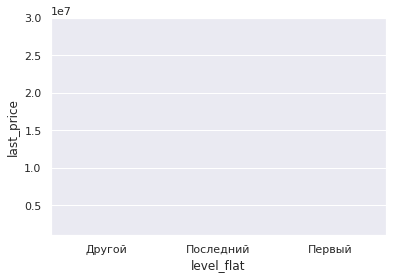

In [58]:
#не получается рядом построить
#fig, (ax1, ax2) = plt.subplots(1, 2)
ax1 = sns.boxplot(x='level_flat', y='last_price', data=SPB_centr);
ax1.set_ylim([1000000,30000000])
#ax2 = sns.boxplot(x='level_flat', y='last_price', data=SPB);
#ax2.set_ylim([1000000,30000000])
plt.show()


В центре SPB продается 4 тысячи квартир. В отличии от основной выборки последние этажи ценятся так же как и средние, возможно дело в красивых панорамных видах. 

In [59]:
set_columns = ['total_area','last_price','rooms','ceiling_height']
data_descr=data[set_columns].describe()
SPB_centr_descr = SPB_centr[set_columns].describe()
display(data_descr)
display(SPB_centr_descr)

,total_area,last_price,rooms,ceiling_height
count,22654.0000,22654.0,22654.000000,22654.000000
mean,inf,inf,2.067891,2.685547
std,inf,NaN,1.066118,0.198853
min,12.0000,inf,0.000000,2.250000
25%,40.0000,inf,1.000000,2.599609
50%,51.1875,inf,2.000000,2.650391
75%,68.0000,inf,3.000000,2.699219
max,900.0000,inf,19.000000,5.601562


,total_area,last_price,rooms,ceiling_height
count,3318.000000,3318.0,3318.000000,3318.000000
mean,inf,inf,2.851417,2.902344
std,inf,NaN,1.443097,0.336182
min,12.000000,inf,0.000000,2.400391
25%,54.023438,inf,2.000000,2.650391
50%,75.000000,inf,3.000000,2.750000
75%,103.921875,inf,4.000000,3.099609
max,900.000000,inf,19.000000,5.601562


/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning:

invalid value encountered in multiply

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning:

invalid value encountered in multiply



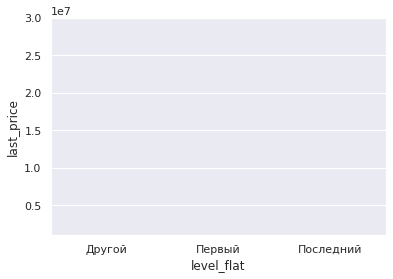

In [60]:
ax1 = sns.boxplot(x='level_flat', y='last_price', data=SPB);
ax1.set_ylim([1000000,30000000])
#ax2 = sns.boxplot(x='level_flat', y='last_price', data=SPB);
#ax2.set_ylim([1000000,30000000])
plt.show()

ValueError: autodetected range of [inf, inf] is not finite

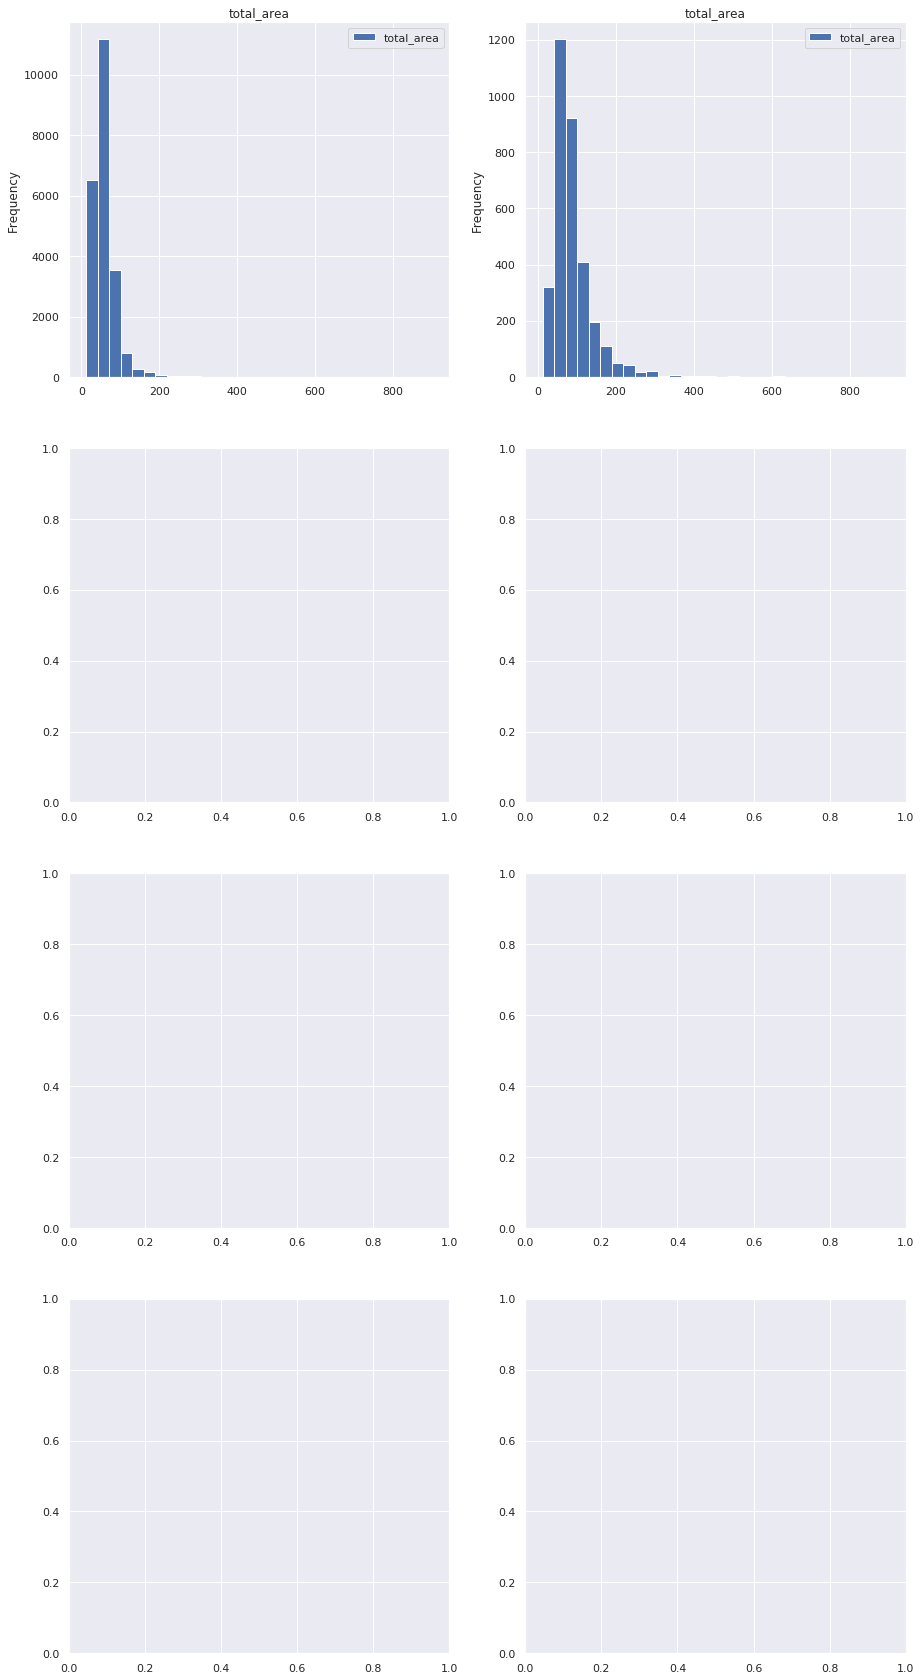

In [61]:
fig,axes = plt.subplots(nrows=4, ncols=2,figsize=(15,30))
_count=0
for column in set_columns:
    #data.hist(column,bins=20)
    data.plot(y=column,title=column,kind='hist',bins=30,ax=axes[_count,0])
             # xlim=(0,data_descr[column][6]))
    SPB_centr.plot(y=column,title=column,kind='hist',bins=30,ax=axes[_count,1])
                   #,xlim=(0,SPB_centr[column][6]))
    _count+=1
    
    


Сравнив данные по квартирам в центре, и квартирам по выборке в целом заметим, 
что площадь у квартир больше чем повыборке в целом. 5-7 комнатных квартир тоже больше. 
Высота потолков 3-3,5 метра это норма.


In [ ]:
#посмотрим как менялась цена с течением времени
data_pivot = SPB.copy()
data_pivot = data_pivot.pivot_table(index=['year','month'], values='sq_m_price', aggfunc='median')
data_pivot_center = SPB_centr.pivot_table(index=['year','month'], values='sq_m_price', aggfunc='median')
display(data_pivot)

In [ ]:
#подскажи пожалуйста как сделать более читаемым, и совместить с графиком другого датафрэйма
ax =data_pivot.plot(kind='line',figsize=(50,20),grid=True,style='-o',fontsize=50,
                linewidth=16, alpha=0.3,legend=True)
data_pivot_center.plot(kind='line',figsize=(50,20),grid=True,style='-o',fontsize=50,
                linewidth=16, alpha=0.3,legend=True,ax=ax,label='цена квадрата в центре')
ax.legend(
   loc='best',
   fontsize=50)

<div class="alert alert-block alert-warning">

Ты можешь также менять размеры легенды с помощью `ax.legend`
    
    

In [ ]:
data_pivot_sq_m_price_rooms =  data.query('rooms<9').pivot_table(index=['year'],columns='rooms', values='sq_m_price', aggfunc='median')
data_pivot_sq_m_price_rooms.plot(kind='area',figsize=(50,20),grid=True,style='-o',fontsize=50,
                linewidth=16, alpha=0.3,legend=True)

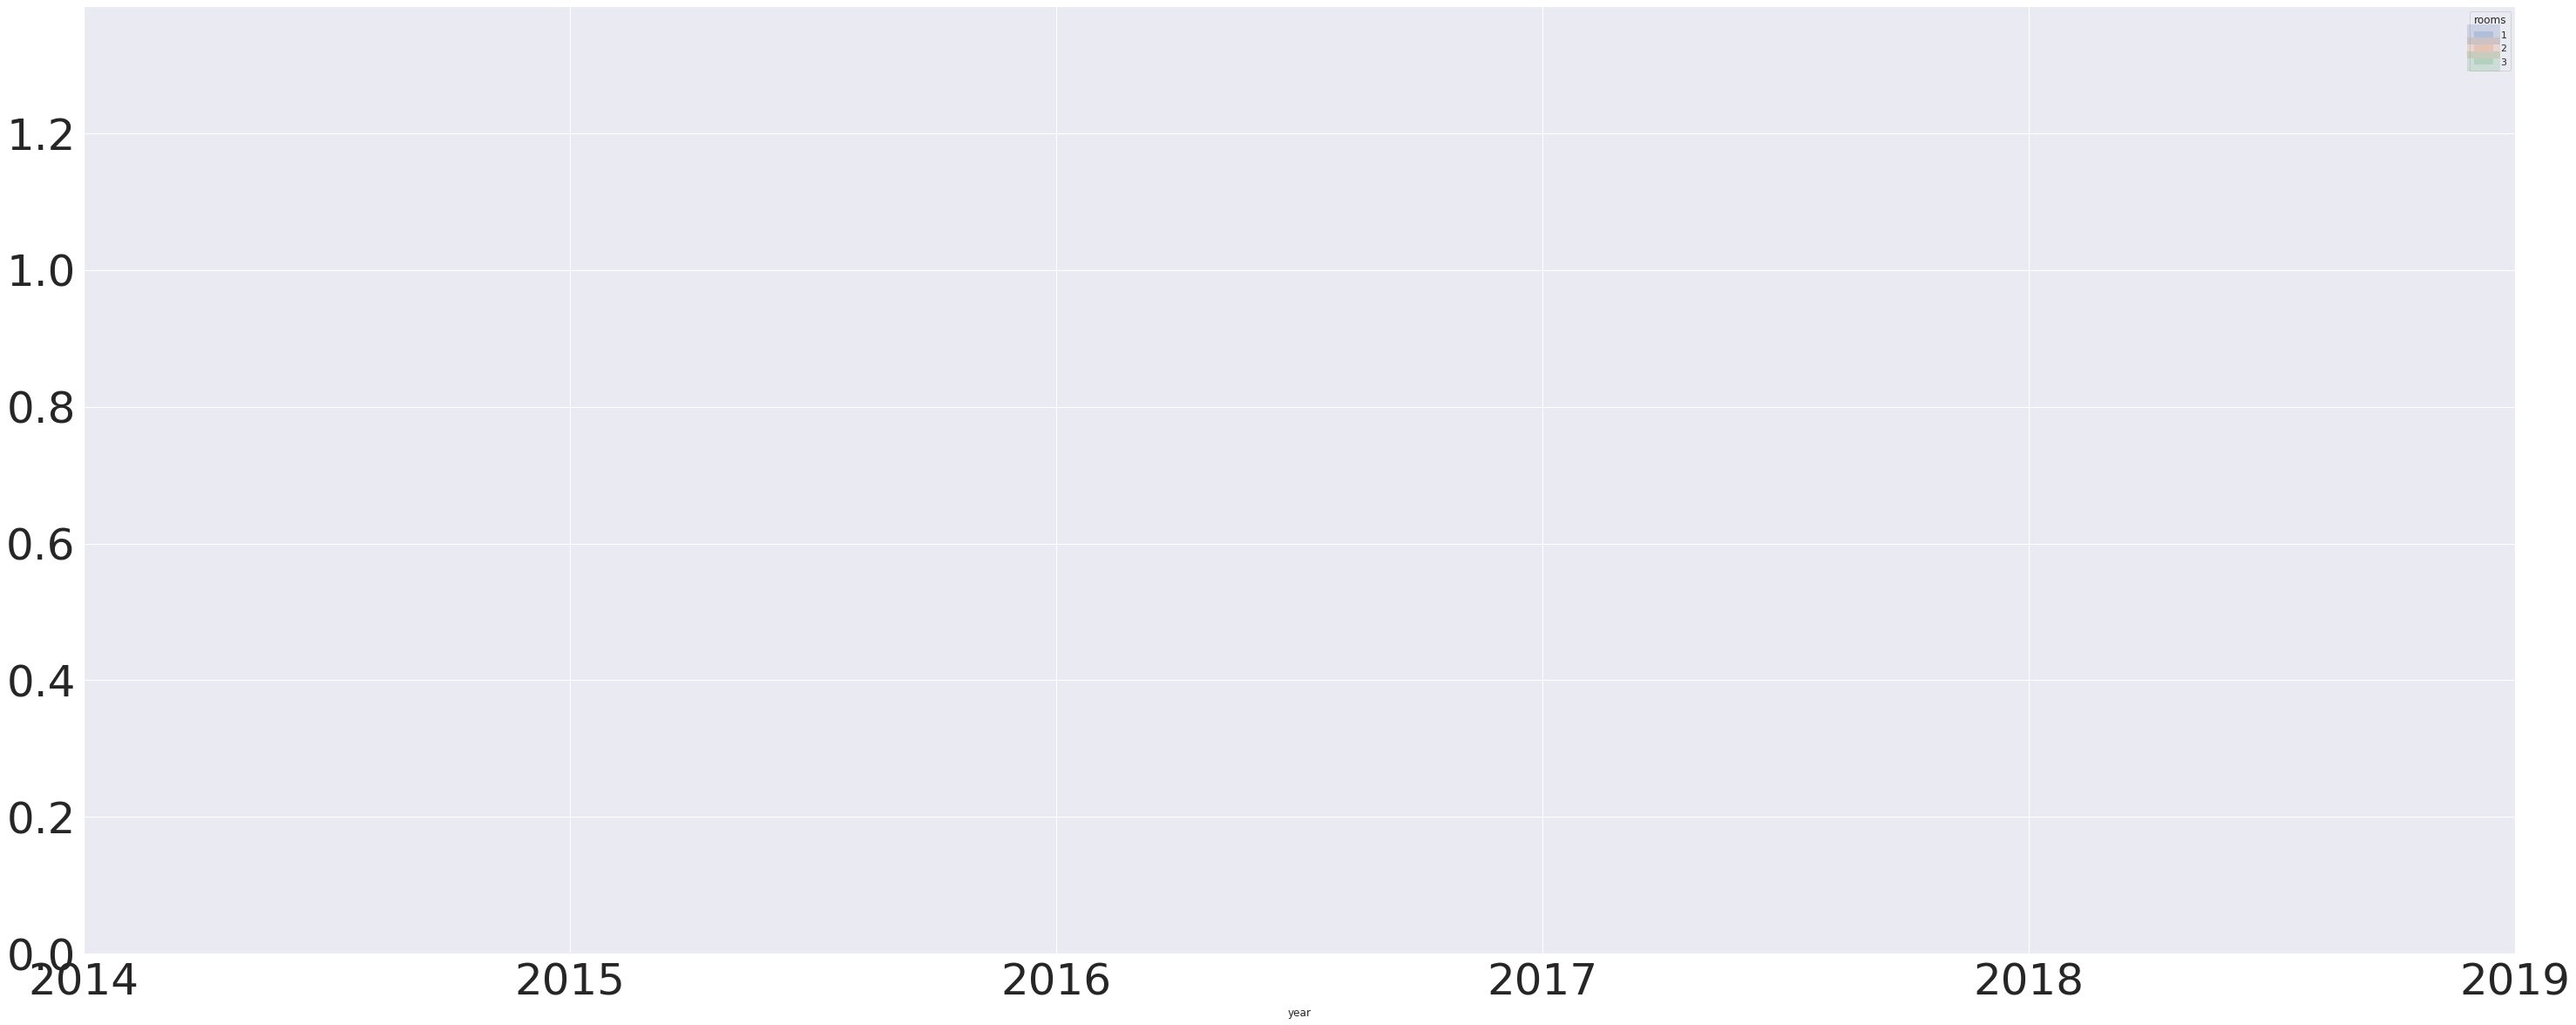

In [62]:
data_pivot_sq_m_price_rooms =  SPB_centr.query('1<=rooms<4').pivot_table(index=['year'],columns='rooms', values='sq_m_price', aggfunc='median')
data_pivot_sq_m_price_rooms.plot(kind='area',figsize=(50,20),grid=True,style='-o',fontsize=50,
                linewidth=16, alpha=0.2,legend=True)

Сравним как менялась цена квадрата в центре и по всему городу СПБ. Видим что по некоторым месяцам недвижимость в центре падала
, а иногда взлетала в вверх. В среднем по городу небыло таких перепадов. Но в целом тренды там и там одинаковы.
Заметим что есть тенденция волотильности стоимости квадрата с квартирами с большим количеством комнат. В 2014 году упала стоимость квадрата в 3 комнатных квартирах
С 2018 года начинается небольшой рост по стоимости квадрата в 1 и 2 комнатных квартирах. У кого небыло собственного жилья, задумываются о его покупке.

### Шаг 5. Общий вывод<a id="55"></a>

К нам попал датасэт с историей продаж 23 тысячи квартир за период с конца 2014 года по начало 2019. 
- В датасэте были выявлены и удалены выбросы, заполнены пропущенные значения.

В данных конечно же есть выбросы и нулевые значения, которые нам предстоит заполнить, но попытаемся все же сделать промежуточные выводы:
- медианное время объекта на продаже 95 дней. Но очень большое СКО. Значит какие то объекты продаются быстро, а какие то висят. Но нужно знать причину, возможно это мошеннические объявления, которые быстро снимают.
- очень большой разброс значений по столбцам cityCenters_nearest, airports_nearest,parks_nearest, ponds_nearest. Скорее это говорит о том что объекты разбросаны по всему городу равномерно, но не исключаем отсутстве достоверных данных. Возможно дело в отдаленных населенных пунктах
- Рассмотрев квантили и медиану параметров cityCenters_nearest и airports_nearest в формате 25%:50%:75% убедимся что расстояния в целом адекватные 9.2:13:16.3 (до центра) и 18.5:26.7:37.3(аэропорт)
- очень большой разброс значений по столбцам cityCenters_nearest, airports_nearest,parks_nearest, ponds_nearest. Скорее это говорит о том что объекты разбросаны по всему городу равномерно, но не исключаем отсутстве достоверных данных
- рассмотрев квантили и медиану параметров cityCenters_nearest и airports_nearest в формате 25%:50%:75% убедимся что расстояния в целом адекватные 9.2:13:16.3 (до центра) и 18.5:26.7:37.3(аэропорт)
- с площадью кухни тоже вроде все впорядке 7:9:12 кв. м соответственно. Есть конечно выбросы 1,3 и 112, с ними будем работать.
- по этажам статистика по этажам, если брать по квантилям 2:4:8 немножко странная для мегаполиса. Но возможно сыграл роль старый фонд и область. 
- посмотрим так же параметры самих домов •	floors_total . 60 этажей в доме - сомнительно. Да и статистика по квантилям немного выше, чем у продающихся квартир 5:9:16. Можно предположить что что-то не так с данными или от нижних этажей избавляются охотнее, а солнечные квартиры   с хорошим видом редко поступают в продажу
-что касается жилой площади   значения адекватны 18:30:42.3. С общей площадью ситуация впорядке 40:52:70. Есть квартиры 900 квадратов, но предположим что это элитная недвижимость. 
- С потолками все в норме 2.52:2.65:2.8 Но с выбросами в 100 метров нужно что-то делать, как и 1 метр тоже не годен для полноценного проживания.(скорее всего ошибка при формировании данных)
- по количеству комнат все впорядке, будем смотреть внимательней на квартиры с 19 комнатами и где нет ни одной. Может техническая ошибка при записи/копировании/заведении данных, а может там продается что то особенное.
- количество фото тоже выглядит правдоподобным 6:9:14
-цена 3.4:4.6:6.8 млн. руб. тоже выглядит реалистичноый

##### Пропущенные данные
- Высота потолков и жилая площадь, площадь кухни - возможно хозяева не владели данной информацией, или просто не стали заморачиваться и смотреть в паспорт. Скорее всего данное поле было не обязательным для заполнения
- is_apartment - скорее всего владельцы пропустили данный пункт, если у них обычная квартира.
- странно что пропущены такие значения как: расстояние до центра(можно посчитать),количество водоемов в округе и время размещения. Тут однозначно какой-то сбой с данными, в следующем модуле будм думать как восстановить эти данные

- Проанализирована популярность первых и последних этажей. В центре оказалось что стоимоть последнего этажа не ниже чем обычного, а первый будет стоить дешевле.
##### Добавили дополнительные метрики:
** цену квадратного метра
** день недели, месяц и год публикации объявления;
**	этаж квартиры; варианты — первый, последний, другой;
**	соотношение жилой и общей площади, а также отношение площади кухни к общей.

- В 2018 году был заметен рост цен, возврастающий тренд которого продолжался до окончания выборки
- Центром можно считать все квартиры в радиусе 8 километров, они самые дорогие.
- Были найдены выбросы по стоимости на 20 и 27 километре от центра. Возможно продавали элитную недвижимость в историческом пригороде Петербурга.
-Сравнили недвижимость в центре с недвижимостью по городу в целом.
-Посчитали за сколько в среднем продают квартиру, и в каком случае можно сказать что она продавалась очень быстро.



### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод